Catch Joe
=========

In [2]:
# Python libs
import json
from collections import Counter
import numpy as np
import pandas as pd
from dython.nominal import cramers_v, theils_u, correlation_ratio
from scipy.stats import randint

# Date/time/timezone
import datetime as dt
import pytz
from geopy.geocoders import Nominatim
from timezonefinder import TimezoneFinder

# scikit-learn
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, roc_auc_score, balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Module settings
mpl.rc("figure", facecolor="white", dpi=144)
pd.set_option('expand_frame_repr', False)  # display dataframe without wrapping

# Data Preparation



### Check data structure



-   Two data files are given: the training data &ldquo;dataset.json&rdquo; and test data &ldquo;verify.json&rdquo;.
-   The training data file is a big json file, about 77MB, so we&rsquo;ll firstly peek into the data file and check its structure.



In [3]:
!head -n 50 dataset.json

[
    {
        "browser": "Firefox",
        "os": "Ubuntu",
        "locale": "ru_RU",
        "user_id": 105,
        "gender": "m",
        "location": "USA/Chicago",
        "sites": [
            {
                "site": "mail.google.com",
                "length": 50
            },
            {
                "site": "toptal.com",
                "length": 132
            },
            {
                "site": "slack.com",
                "length": 65
            },
            {
                "site": "lenta.ru",
                "length": 59
            },
            {
                "site": "youtube.com",
                "length": 67
            },
            {
                "site": "chitay-knigi.ru",
                "length": 108
            }
        ],
        "time": "09:03:00",
        "date": "2017-01-08"
    },
    {
        "browser": "Firefox",
        "os": "Windows 8",
        "locale": "pl-PL",
        "user_id": 11,
        "gender": "m",
        "locat

In [4]:
!head -n 50 test.json

[
    {
        "browser": "Chrome",
        "os": "Ubuntu",
        "locale": "ru_RU",
        "gender": "m",
        "location": "Canada/Toronto",
        "sites": [
            {
                "site": "mail.google.com",
                "length": 383
            },
            {
                "site": "vk.com",
                "length": 108
            },
            {
                "site": "toptal.com",
                "length": 138
            },
            {
                "site": "lenta.ru",
                "length": 47
            },
            {
                "site": "slack.com",
                "length": 93
            },
            {
                "site": "gazzettaobjects.it",
                "length": 92
            },
            {
                "site": "youtube.com",
                "length": 48
            }
        ],
        "time": "16:59:00",
        "date": "2017-09-05"
    },
    {
        "browser": "Chrome",
        "os": "Ubuntu",
        "locale":

-   It looks the training data have 9 fields, and the sites fields is a nested list, which contains all the sites the user visits in the session.
-   To transfer the nested json data into useful features, we'll vectorize the sites column.



### Load data



In [5]:
with open('dataset.json', 'r') as f:
     data_json_struct = json.loads(f.read())
user_sessions = pd.DataFrame(data_json_struct)
print(data_json_struct[0])

{'browser': 'Firefox', 'os': 'Ubuntu', 'locale': 'ru_RU', 'user_id': 105, 'gender': 'm', 'location': 'USA/Chicago', 'sites': [{'site': 'mail.google.com', 'length': 50}, {'site': 'toptal.com', 'length': 132}, {'site': 'slack.com', 'length': 65}, {'site': 'lenta.ru', 'length': 59}, {'site': 'youtube.com', 'length': 67}, {'site': 'chitay-knigi.ru', 'length': 108}], 'time': '09:03:00', 'date': '2017-01-08'}


### Data Inspection



In [6]:
user_sessions.head(20)
print('\n')
user_sessions.info()

,browser,os,locale,user_id,gender,location,sites,time,date
0,Firefox,Ubuntu,ru_RU,105,m,USA/Chicago,"[{'site': 'mail.google.com', 'length': 50}, {'...",09:03:00,2017-01-08
1,Firefox,Windows 8,pl-PL,11,m,USA/Chicago,"[{'site': 'meduza.org', 'length': 40}, {'site'...",13:57:00,2016-10-05
2,Chrome,Ubuntu,zh-CN,17,m,Singapore/Singapore,"[{'site': 'facebook.net', 'length': 74}, {'sit...",02:06:00,2017-03-28
3,Chrome,Windows 10,pt-BR,134,f,Australia/Sydney,"[{'site': 'verisign.com', 'length': 111}, {'si...",21:49:00,2017-06-25
4,Firefox,Windows 10,en-SG,92,f,USA/Chicago,"[{'site': 'live.com', 'length': 79}, {'site': ...",00:05:00,2016-02-10
5,Internet Explorer,Windows 8,xh-ZA,120,m,France/Paris,"[{'site': 'cnn.com', 'length': 65}, {'site': '...",14:55:00,2017-03-28
6,Chrome,Ubuntu,ja-JP,158,f,Germany/Berlin,"[{'site': 'toptal.com', 'length': 59}, {'site'...",21:26:00,2017-08-14
7,Chrome,Windows 10,en-NZ,34,m,USA/Chicago,"[{'site': 'google.com', 'length': 86}, {'site'...",23:00:00,2016-02-19
8,Internet Explorer,Windows 7,en-CA,173,m,USA/San Francisco,"[{'site': 'booking.com', 'length': 93}, {'site...",17:08:00,2017-01-04
9,Safari,MacOS,zh-CN,51,m,Australia/Sydney,"[{'site': 'bing.com', 'length': 166}, {'site':...",22:31:00,2016-01-20




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   browser   80000 non-null  object
 1   os        80000 non-null  object
 2   locale    80000 non-null  object
 3   user_id   80000 non-null  int64 
 4   gender    80000 non-null  object
 5   location  80000 non-null  object
 6   sites     80000 non-null  object
 7   time      80000 non-null  object
 8   date      80000 non-null  object
dtypes: int64(1), object(8)
memory usage: 5.5+ MB


In [7]:
user_sessions.query("sites.str.len() == 0")

,browser,os,locale,user_id,gender,location,sites,time,date
312,Chrome,Windows 7,uk-UA,12,m,Canada/Vancouver,[],17:45:00,2017-08-12
604,Firefox,Windows 10,en-GB,78,f,Japan/Tokyo,[],08:36:00,2016-11-01
821,Firefox,Windows 8,pt-BR,172,m,China/Shanghai,[],05:48:00,2016-10-13
945,Chrome,Windows 8,en-AU,108,m,France/Paris,[],11:24:00,2016-10-14
1073,Internet Explorer,Windows 10,nl-NL,75,m,Germany/Berlin,[],01:57:00,2016-06-12
...,...,...,...,...,...,...,...,...,...
78883,Chrome,Windows 10,vi-VN,93,m,Singapore/Singapore,[],12:10:00,2016-03-20
79149,Safari,MacOS,it-IT,32,m,Netherlands/Amsterdam,[],13:03:00,2016-11-23
79603,Firefox,Windows 8,pt-BR,172,m,China/Shanghai,[],05:28:00,2016-08-12
79903,Safari,MacOS,nl-NL,197,m,Canada/Toronto,[],02:37:00,2016-12-09


### Prepare Data: Impute Empty Sites and Add Custom Features



#### Impute empty sites



In [8]:
empty_sites_index = user_sessions.query("sites.str.len() == 0").index
user_sessions.loc[empty_sites_index, 'sites'] = user_sessions.loc[empty_sites_index]['sites'].apply(lambda sites: sites + [{'site': 'NONE.NONE', 'length': 0}])
user_sessions.loc[empty_sites_index]

,browser,os,locale,user_id,gender,location,sites,time,date
312,Chrome,Windows 7,uk-UA,12,m,Canada/Vancouver,"[{'site': 'NONE.NONE', 'length': 0}]",17:45:00,2017-08-12
604,Firefox,Windows 10,en-GB,78,f,Japan/Tokyo,"[{'site': 'NONE.NONE', 'length': 0}]",08:36:00,2016-11-01
821,Firefox,Windows 8,pt-BR,172,m,China/Shanghai,"[{'site': 'NONE.NONE', 'length': 0}]",05:48:00,2016-10-13
945,Chrome,Windows 8,en-AU,108,m,France/Paris,"[{'site': 'NONE.NONE', 'length': 0}]",11:24:00,2016-10-14
1073,Internet Explorer,Windows 10,nl-NL,75,m,Germany/Berlin,"[{'site': 'NONE.NONE', 'length': 0}]",01:57:00,2016-06-12
...,...,...,...,...,...,...,...,...,...
78883,Chrome,Windows 10,vi-VN,93,m,Singapore/Singapore,"[{'site': 'NONE.NONE', 'length': 0}]",12:10:00,2016-03-20
79149,Safari,MacOS,it-IT,32,m,Netherlands/Amsterdam,"[{'site': 'NONE.NONE', 'length': 0}]",13:03:00,2016-11-23
79603,Firefox,Windows 8,pt-BR,172,m,China/Shanghai,"[{'site': 'NONE.NONE', 'length': 0}]",05:28:00,2016-08-12
79903,Safari,MacOS,nl-NL,197,m,Canada/Toronto,"[{'site': 'NONE.NONE', 'length': 0}]",02:37:00,2016-12-09


#### Combine date/time columns and convert from string to datetime type



In [9]:
user_sessions['start_dt'] = pd.to_datetime(user_sessions['date'] + ' ' + user_sessions['time'], utc=True)
user_sessions.drop(['time', 'date'], axis=1, inplace=True)
user_sessions

,browser,os,locale,user_id,gender,location,sites,start_dt
0,Firefox,Ubuntu,ru_RU,105,m,USA/Chicago,"[{'site': 'mail.google.com', 'length': 50}, {'...",2017-01-08 09:03:00+00:00
1,Firefox,Windows 8,pl-PL,11,m,USA/Chicago,"[{'site': 'meduza.org', 'length': 40}, {'site'...",2016-10-05 13:57:00+00:00
2,Chrome,Ubuntu,zh-CN,17,m,Singapore/Singapore,"[{'site': 'facebook.net', 'length': 74}, {'sit...",2017-03-28 02:06:00+00:00
3,Chrome,Windows 10,pt-BR,134,f,Australia/Sydney,"[{'site': 'verisign.com', 'length': 111}, {'si...",2017-06-25 21:49:00+00:00
4,Firefox,Windows 10,en-SG,92,f,USA/Chicago,"[{'site': 'live.com', 'length': 79}, {'site': ...",2016-02-10 00:05:00+00:00
...,...,...,...,...,...,...,...,...
79995,Chrome,Windows 10,pt-PT,178,m,New Zealand/Auckland,"[{'site': 'vk.com', 'length': 126}, {'site': '...",2016-12-30 06:02:00+00:00
79996,Safari,MacOS,it-IT,32,m,Netherlands/Amsterdam,"[{'site': 'slack.com', 'length': 74}, {'site':...",2017-01-27 10:27:00+00:00
79997,Firefox,Ubuntu,ru_RU,0,m,USA/Chicago,"[{'site': 'vk.com', 'length': 44}, {'site': 's...",2017-03-13 17:55:00+00:00
79998,Firefox,Windows 10,ru_RU,56,m,France/Paris,"[{'site': 'lenta.ru', 'length': 82}, {'site': ...",2016-12-06 14:17:00+00:00


#### Convert start time to local time



-   A class that converts city name to timezone



In [10]:
class TimezoneByCity:
    def __init__(self):
        self.geolocator = Nominatim(user_agent="geoapiExercises")
        self.tzfinder = TimezoneFinder()

    def tz_name(self, city: str):
        loc = self.geolocator.geocode(city)
        tz_name = self.tzfinder.timezone_at(lng=loc.longitude, lat=loc.latitude)
        return tz_name

    def tz(self, city: str):
        tz_name = self.tz_name(city)
        return pytz.timezone(tz_name)

-   Build timezone table that maps country/city to timezone



In [11]:
tz_by_city = TimezoneByCity()
timezone_tbl = {loc: tz_by_city.tz_name(loc.split('/')[1]) for loc in  user_sessions.location.unique()}
print(timezone_tbl)

{'USA/Chicago': 'America/Chicago', 'Singapore/Singapore': 'Asia/Singapore', 'Australia/Sydney': 'Australia/Sydney', 'France/Paris': 'Europe/Paris', 'Germany/Berlin': 'Europe/Berlin', 'USA/San Francisco': 'America/Los_Angeles', 'China/Shanghai': 'Asia/Shanghai', 'New Zealand/Auckland': 'Pacific/Auckland', 'Malaysia/Kuala Lumpur': 'Asia/Kuala_Lumpur', 'USA/New York': 'America/New_York', 'Russia/Moscow': 'Europe/Moscow', 'Brazil/Rio de Janeiro': 'America/Sao_Paulo', 'Canada/Toronto': 'America/Toronto', 'Spain/Madrid': 'Europe/Madrid', 'USA/Miami': 'America/New_York', 'India/Delhi': 'Asia/Kolkata', 'Netherlands/Amsterdam': 'Europe/Amsterdam', 'UK/London': 'Europe/London', 'Japan/Tokyo': 'Asia/Tokyo', 'Italy/Rome': 'Europe/Rome', 'Canada/Vancouver': 'America/Vancouver'}


-   Add local_time column to data



In [12]:
user_sessions['local_time'] = user_sessions.apply(lambda row: row['start_dt'].tz_convert(timezone_tbl[row['location']]).tz_localize(None), axis=1)
user_sessions

,browser,os,locale,user_id,gender,location,sites,start_dt,local_time
0,Firefox,Ubuntu,ru_RU,105,m,USA/Chicago,"[{'site': 'mail.google.com', 'length': 50}, {'...",2017-01-08 09:03:00+00:00,2017-01-08 03:03:00
1,Firefox,Windows 8,pl-PL,11,m,USA/Chicago,"[{'site': 'meduza.org', 'length': 40}, {'site'...",2016-10-05 13:57:00+00:00,2016-10-05 08:57:00
2,Chrome,Ubuntu,zh-CN,17,m,Singapore/Singapore,"[{'site': 'facebook.net', 'length': 74}, {'sit...",2017-03-28 02:06:00+00:00,2017-03-28 10:06:00
3,Chrome,Windows 10,pt-BR,134,f,Australia/Sydney,"[{'site': 'verisign.com', 'length': 111}, {'si...",2017-06-25 21:49:00+00:00,2017-06-26 07:49:00
4,Firefox,Windows 10,en-SG,92,f,USA/Chicago,"[{'site': 'live.com', 'length': 79}, {'site': ...",2016-02-10 00:05:00+00:00,2016-02-09 18:05:00
...,...,...,...,...,...,...,...,...,...
79995,Chrome,Windows 10,pt-PT,178,m,New Zealand/Auckland,"[{'site': 'vk.com', 'length': 126}, {'site': '...",2016-12-30 06:02:00+00:00,2016-12-30 19:02:00
79996,Safari,MacOS,it-IT,32,m,Netherlands/Amsterdam,"[{'site': 'slack.com', 'length': 74}, {'site':...",2017-01-27 10:27:00+00:00,2017-01-27 11:27:00
79997,Firefox,Ubuntu,ru_RU,0,m,USA/Chicago,"[{'site': 'vk.com', 'length': 44}, {'site': 's...",2017-03-13 17:55:00+00:00,2017-03-13 12:55:00
79998,Firefox,Windows 10,ru_RU,56,m,France/Paris,"[{'site': 'lenta.ru', 'length': 82}, {'site': ...",2016-12-06 14:17:00+00:00,2016-12-06 15:17:00


#### Split starting date and time to year / month / day / weekday and start_hour



In [13]:
user_sessions["year"] = user_sessions.local_time.dt.year
user_sessions["month"] = user_sessions.local_time.dt.month
user_sessions["day"] = user_sessions.local_time.dt.day
user_sessions["weekday"] = user_sessions.local_time.dt.weekday
user_sessions["start_hour"] = user_sessions.local_time.dt.hour
user_sessions

,browser,os,locale,user_id,gender,location,sites,start_dt,local_time,year,month,day,weekday,start_hour
0,Firefox,Ubuntu,ru_RU,105,m,USA/Chicago,"[{'site': 'mail.google.com', 'length': 50}, {'...",2017-01-08 09:03:00+00:00,2017-01-08 03:03:00,2017,1,8,6,3
1,Firefox,Windows 8,pl-PL,11,m,USA/Chicago,"[{'site': 'meduza.org', 'length': 40}, {'site'...",2016-10-05 13:57:00+00:00,2016-10-05 08:57:00,2016,10,5,2,8
2,Chrome,Ubuntu,zh-CN,17,m,Singapore/Singapore,"[{'site': 'facebook.net', 'length': 74}, {'sit...",2017-03-28 02:06:00+00:00,2017-03-28 10:06:00,2017,3,28,1,10
3,Chrome,Windows 10,pt-BR,134,f,Australia/Sydney,"[{'site': 'verisign.com', 'length': 111}, {'si...",2017-06-25 21:49:00+00:00,2017-06-26 07:49:00,2017,6,26,0,7
4,Firefox,Windows 10,en-SG,92,f,USA/Chicago,"[{'site': 'live.com', 'length': 79}, {'site': ...",2016-02-10 00:05:00+00:00,2016-02-09 18:05:00,2016,2,9,1,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,Chrome,Windows 10,pt-PT,178,m,New Zealand/Auckland,"[{'site': 'vk.com', 'length': 126}, {'site': '...",2016-12-30 06:02:00+00:00,2016-12-30 19:02:00,2016,12,30,4,19
79996,Safari,MacOS,it-IT,32,m,Netherlands/Amsterdam,"[{'site': 'slack.com', 'length': 74}, {'site':...",2017-01-27 10:27:00+00:00,2017-01-27 11:27:00,2017,1,27,4,11
79997,Firefox,Ubuntu,ru_RU,0,m,USA/Chicago,"[{'site': 'vk.com', 'length': 44}, {'site': 's...",2017-03-13 17:55:00+00:00,2017-03-13 12:55:00,2017,3,13,0,12
79998,Firefox,Windows 10,ru_RU,56,m,France/Paris,"[{'site': 'lenta.ru', 'length': 82}, {'site': ...",2016-12-06 14:17:00+00:00,2016-12-06 15:17:00,2016,12,6,1,15


#### Sine/Cosine transform of local start time



In [14]:
start_dt_normalized = (user_sessions['local_time'] - user_sessions['local_time'].dt.normalize()) / pd.Timedelta('1 second') / 86400
user_sessions['start_sin'] = np.sin(2*np.pi* (start_dt_normalized))
user_sessions['start_cos'] = np.cos(2*np.pi* (start_dt_normalized))
user_sessions

,browser,os,locale,user_id,gender,location,sites,start_dt,local_time,year,month,day,weekday,start_hour,start_sin,start_cos
0,Firefox,Ubuntu,ru_RU,105,m,USA/Chicago,"[{'site': 'mail.google.com', 'length': 50}, {'...",2017-01-08 09:03:00+00:00,2017-01-08 03:03:00,2017,1,8,6,3,0.716302,0.697790
1,Firefox,Windows 8,pl-PL,11,m,USA/Chicago,"[{'site': 'meduza.org', 'length': 40}, {'site'...",2016-10-05 13:57:00+00:00,2016-10-05 08:57:00,2016,10,5,2,8,0.716302,-0.697790
2,Chrome,Ubuntu,zh-CN,17,m,Singapore/Singapore,"[{'site': 'facebook.net', 'length': 74}, {'sit...",2017-03-28 02:06:00+00:00,2017-03-28 10:06:00,2017,3,28,1,10,0.477159,-0.878817
3,Chrome,Windows 10,pt-BR,134,f,Australia/Sydney,"[{'site': 'verisign.com', 'length': 111}, {'si...",2017-06-25 21:49:00+00:00,2017-06-26 07:49:00,2017,6,26,0,7,0.889017,-0.457874
4,Firefox,Windows 10,en-SG,92,f,USA/Chicago,"[{'site': 'live.com', 'length': 79}, {'site': ...",2016-02-10 00:05:00+00:00,2016-02-09 18:05:00,2016,2,9,1,18,-0.999762,0.021815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,Chrome,Windows 10,pt-PT,178,m,New Zealand/Auckland,"[{'site': 'vk.com', 'length': 126}, {'site': '...",2016-12-30 06:02:00+00:00,2016-12-30 19:02:00,2016,12,30,4,19,-0.963630,0.267238
79996,Safari,MacOS,it-IT,32,m,Netherlands/Amsterdam,"[{'site': 'slack.com', 'length': 74}, {'site':...",2017-01-27 10:27:00+00:00,2017-01-27 11:27:00,2017,1,27,4,11,0.143493,-0.989651
79997,Firefox,Ubuntu,ru_RU,0,m,USA/Chicago,"[{'site': 'vk.com', 'length': 44}, {'site': 's...",2017-03-13 17:55:00+00:00,2017-03-13 12:55:00,2017,3,13,0,12,-0.237686,-0.971342
79998,Firefox,Windows 10,ru_RU,56,m,France/Paris,"[{'site': 'lenta.ru', 'length': 82}, {'site': ...",2016-12-06 14:17:00+00:00,2016-12-06 15:17:00,2016,12,6,1,15,-0.757565,-0.652760


#### Split location to country and city



In [15]:
user_sessions[['country', 'city']] = user_sessions['location'].str.split('/', expand=True)
user_sessions

,browser,os,locale,user_id,gender,location,sites,start_dt,local_time,year,month,day,weekday,start_hour,start_sin,start_cos,country,city
0,Firefox,Ubuntu,ru_RU,105,m,USA/Chicago,"[{'site': 'mail.google.com', 'length': 50}, {'...",2017-01-08 09:03:00+00:00,2017-01-08 03:03:00,2017,1,8,6,3,0.716302,0.697790,USA,Chicago
1,Firefox,Windows 8,pl-PL,11,m,USA/Chicago,"[{'site': 'meduza.org', 'length': 40}, {'site'...",2016-10-05 13:57:00+00:00,2016-10-05 08:57:00,2016,10,5,2,8,0.716302,-0.697790,USA,Chicago
2,Chrome,Ubuntu,zh-CN,17,m,Singapore/Singapore,"[{'site': 'facebook.net', 'length': 74}, {'sit...",2017-03-28 02:06:00+00:00,2017-03-28 10:06:00,2017,3,28,1,10,0.477159,-0.878817,Singapore,Singapore
3,Chrome,Windows 10,pt-BR,134,f,Australia/Sydney,"[{'site': 'verisign.com', 'length': 111}, {'si...",2017-06-25 21:49:00+00:00,2017-06-26 07:49:00,2017,6,26,0,7,0.889017,-0.457874,Australia,Sydney
4,Firefox,Windows 10,en-SG,92,f,USA/Chicago,"[{'site': 'live.com', 'length': 79}, {'site': ...",2016-02-10 00:05:00+00:00,2016-02-09 18:05:00,2016,2,9,1,18,-0.999762,0.021815,USA,Chicago
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,Chrome,Windows 10,pt-PT,178,m,New Zealand/Auckland,"[{'site': 'vk.com', 'length': 126}, {'site': '...",2016-12-30 06:02:00+00:00,2016-12-30 19:02:00,2016,12,30,4,19,-0.963630,0.267238,New Zealand,Auckland
79996,Safari,MacOS,it-IT,32,m,Netherlands/Amsterdam,"[{'site': 'slack.com', 'length': 74}, {'site':...",2017-01-27 10:27:00+00:00,2017-01-27 11:27:00,2017,1,27,4,11,0.143493,-0.989651,Netherlands,Amsterdam
79997,Firefox,Ubuntu,ru_RU,0,m,USA/Chicago,"[{'site': 'vk.com', 'length': 44}, {'site': 's...",2017-03-13 17:55:00+00:00,2017-03-13 12:55:00,2017,3,13,0,12,-0.237686,-0.971342,USA,Chicago
79998,Firefox,Windows 10,ru_RU,56,m,France/Paris,"[{'site': 'lenta.ru', 'length': 82}, {'site': ...",2016-12-06 14:17:00+00:00,2016-12-06 15:17:00,2016,12,6,1,15,-0.757565,-0.652760,France,Paris


#### Get total length of each user session



In [16]:
user_sessions['length_session'] = user_sessions['sites'].apply(lambda session_sites: sum(site_entry['length'] for site_entry in session_sites))
user_sessions

,browser,os,locale,user_id,gender,location,sites,start_dt,local_time,year,month,day,weekday,start_hour,start_sin,start_cos,country,city,length_session
0,Firefox,Ubuntu,ru_RU,105,m,USA/Chicago,"[{'site': 'mail.google.com', 'length': 50}, {'...",2017-01-08 09:03:00+00:00,2017-01-08 03:03:00,2017,1,8,6,3,0.716302,0.697790,USA,Chicago,481
1,Firefox,Windows 8,pl-PL,11,m,USA/Chicago,"[{'site': 'meduza.org', 'length': 40}, {'site'...",2016-10-05 13:57:00+00:00,2016-10-05 08:57:00,2016,10,5,2,8,0.716302,-0.697790,USA,Chicago,1076
2,Chrome,Ubuntu,zh-CN,17,m,Singapore/Singapore,"[{'site': 'facebook.net', 'length': 74}, {'sit...",2017-03-28 02:06:00+00:00,2017-03-28 10:06:00,2017,3,28,1,10,0.477159,-0.878817,Singapore,Singapore,1280
3,Chrome,Windows 10,pt-BR,134,f,Australia/Sydney,"[{'site': 'verisign.com', 'length': 111}, {'si...",2017-06-25 21:49:00+00:00,2017-06-26 07:49:00,2017,6,26,0,7,0.889017,-0.457874,Australia,Sydney,1323
4,Firefox,Windows 10,en-SG,92,f,USA/Chicago,"[{'site': 'live.com', 'length': 79}, {'site': ...",2016-02-10 00:05:00+00:00,2016-02-09 18:05:00,2016,2,9,1,18,-0.999762,0.021815,USA,Chicago,224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,Chrome,Windows 10,pt-PT,178,m,New Zealand/Auckland,"[{'site': 'vk.com', 'length': 126}, {'site': '...",2016-12-30 06:02:00+00:00,2016-12-30 19:02:00,2016,12,30,4,19,-0.963630,0.267238,New Zealand,Auckland,509
79996,Safari,MacOS,it-IT,32,m,Netherlands/Amsterdam,"[{'site': 'slack.com', 'length': 74}, {'site':...",2017-01-27 10:27:00+00:00,2017-01-27 11:27:00,2017,1,27,4,11,0.143493,-0.989651,Netherlands,Amsterdam,267
79997,Firefox,Ubuntu,ru_RU,0,m,USA/Chicago,"[{'site': 'vk.com', 'length': 44}, {'site': 's...",2017-03-13 17:55:00+00:00,2017-03-13 12:55:00,2017,3,13,0,12,-0.237686,-0.971342,USA,Chicago,698
79998,Firefox,Windows 10,ru_RU,56,m,France/Paris,"[{'site': 'lenta.ru', 'length': 82}, {'site': ...",2016-12-06 14:17:00+00:00,2016-12-06 15:17:00,2016,12,6,1,15,-0.757565,-0.652760,France,Paris,696


### Vectorize top sites using TF-IDF



In [17]:
n_top = 100

joe_cnt = Counter()
for sites_session in user_sessions.query('user_id == 0')['sites']:
    for site_entry in sites_session:
        joe_cnt.update({site_entry['site']: site_entry['length']})

joe_top_sites, _ = zip(*joe_cnt.most_common(n_top))

print("Total sites joe visited: ", len(joe_cnt))
print(f"Top {n_top} sites joe visited: \n", joe_top_sites[:100])

Total sites joe visited:  1166
Top 100 sites joe visited: 
 ('lenta.ru', 'toptal.com', 'mail.google.com', 'slack.com', 'vk.com', 'youtube.com', 'mairie-gruson.fr', 'tdg.ch', 'smbg.fr', 'multiplayer.com', 'free.fr', 'play3-live.com', '127.107', 'rollingstone.com', 'crous-clermont.fr', 'machine-outil.com', 'starbucks.com', 'arooze.com', 'jeux-mini.com', 'games.la', 'fntp.fr', 'yale.edu', 'ireasoning.com', 'marianne.net', 'doctrine-project.org', 'annonceetudiant.com', 'dico-ecolo.com', 'getadblock.com', 'tecnitude.com', 'alluserpics.com', 'iufm.fr', 'geowiki.fr', 'moonbasa.com', 'loreal-finance.com', 'apogee-systems.com', 'mgc-prevention.fr', 'lacoope.org', 'alexgorbatchev.com', 'bookryanair.com', 'wikio.fr', 'cpubenchmark.net', 'thequestionsnetwork.org', 'seloger.com', 'lektorat.de', 'coza.net', 'linuxplanet.com', 'gagnantduprix.com', 'smart-tribune.com', 'onescreen.net', 'obspm.fr', 'granthweb.com', 'restotel.net', 'citea.info', 'virginmobile.fr', 'imaginetonfutur.com', 'encyclopediadra

In [18]:
n_top = 100

all_cnt = Counter()
for sites_session in user_sessions['sites']:
    for site_entry in sites_session:
        all_cnt.update({site_entry['site']: site_entry['length']})

all_top_sites, _ = zip(*all_cnt.most_common(n_top))
print("Total sites all users visited: ", len(all_cnt))
print(f"Top {n_top} sites all users visited: \n", all_top_sites[:100])

Total sites all users visited:  11132
Top 100 sites all users visited: 
 ('youtube.com', 'toptal.com', 'slack.com', 'lenta.ru', 'vk.com', 'mail.google.com', 'oracle.com', 'wikimedia.org', 'googleapis.com', 'vimeo.com', 'airbnb.com', 'geotrust.com', 'google.com', 'booking.com', 'facebook.com', 'live.com', 'cedexis.com', 'ggpht.com', 'baidu.com', 'ytimg.com', 'facebook.net', 'mangafox.me', 'googlevideo.com', 'verisign.com', 'lijit.com', 'yahoo.com', 'openclassrooms.com', 'twitter.com', 'cloudfront.net', 'meduza.org', 'digicert.com', 'disqus.com', 'jboss.org', 'microsoft.com', 'instagram.com', 'wikipedia.org', 'bing.com', 'bing.net', 'skyscanner.com', 'com.cn', 'cnn.com', 'allpostersimages.com', 'ecns.cn', 'csdn.net', 'food-4tots.com', 'trafiz.net', 'ca-centrefrance.fr', 'designmodo.com', 'stid-france.com', 'technoratimedia.com', 'mlmd.fr', 'irs01.net', 'daxon.fr', 'synten.com', 'ac-mayotte.fr', 'retetedesuflet.ro', 'dmca.com', 'megaportail.eu', 'autotitre.com', 'letudiant.fr', 'bookryana

In [20]:
def get_topsites_length(session_sites: list, top_sites=all_top_sites):
    topsites_len_dict = dict.fromkeys(top_sites, 0)
    for site_entry in session_sites:
        site = site_entry['site']
        if site in topsites_len_dict:
            topsites_len_dict[site] += site_entry['length']
    return list(topsites_len_dict.values())

topsites_length = user_sessions['sites'].apply(get_topsites_length)
topsites_length

0        [67, 132, 65, 59, 0, 50, 0, 0, 0, 0, 0, 0, 0, ...
1        [202, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
2        [109, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
3        [0, 0, 191, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 112,...
4        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                               ...                        
79995    [46, 0, 63, 0, 126, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
79996    [43, 0, 74, 0, 70, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
79997    [0, 0, 71, 0, 44, 54, 0, 0, 0, 0, 0, 0, 0, 0, ...
79998    [251, 103, 0, 82, 133, 127, 0, 0, 0, 0, 0, 0, ...
79999    [0, 0, 0, 0, 0, 0, 118, 0, 0, 0, 0, 0, 145, 0,...
Name: sites, Length: 80000, dtype: object

In [21]:
tfidf = TfidfTransformer()
topsites_tfidf = tfidf.fit_transform(topsites_length.values.tolist())
topsites_tfidf.toarray()[:2]

array([[0.3356709 , 0.73258813, 0.36172768, 0.35462643, 0.        ,
        0.30664778, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

### Add binary class label: Joe=0, Other users=1



In [22]:
user_sessions['target'] = (user_sessions['user_id'] != 0).astype(int)
user_sessions

,browser,os,locale,user_id,gender,location,sites,start_dt,local_time,year,month,day,weekday,start_hour,start_sin,start_cos,country,city,length_session,target
0,Firefox,Ubuntu,ru_RU,105,m,USA/Chicago,"[{'site': 'mail.google.com', 'length': 50}, {'...",2017-01-08 09:03:00+00:00,2017-01-08 03:03:00,2017,1,8,6,3,0.716302,0.697790,USA,Chicago,481,1
1,Firefox,Windows 8,pl-PL,11,m,USA/Chicago,"[{'site': 'meduza.org', 'length': 40}, {'site'...",2016-10-05 13:57:00+00:00,2016-10-05 08:57:00,2016,10,5,2,8,0.716302,-0.697790,USA,Chicago,1076,1
2,Chrome,Ubuntu,zh-CN,17,m,Singapore/Singapore,"[{'site': 'facebook.net', 'length': 74}, {'sit...",2017-03-28 02:06:00+00:00,2017-03-28 10:06:00,2017,3,28,1,10,0.477159,-0.878817,Singapore,Singapore,1280,1
3,Chrome,Windows 10,pt-BR,134,f,Australia/Sydney,"[{'site': 'verisign.com', 'length': 111}, {'si...",2017-06-25 21:49:00+00:00,2017-06-26 07:49:00,2017,6,26,0,7,0.889017,-0.457874,Australia,Sydney,1323,1
4,Firefox,Windows 10,en-SG,92,f,USA/Chicago,"[{'site': 'live.com', 'length': 79}, {'site': ...",2016-02-10 00:05:00+00:00,2016-02-09 18:05:00,2016,2,9,1,18,-0.999762,0.021815,USA,Chicago,224,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,Chrome,Windows 10,pt-PT,178,m,New Zealand/Auckland,"[{'site': 'vk.com', 'length': 126}, {'site': '...",2016-12-30 06:02:00+00:00,2016-12-30 19:02:00,2016,12,30,4,19,-0.963630,0.267238,New Zealand,Auckland,509,1
79996,Safari,MacOS,it-IT,32,m,Netherlands/Amsterdam,"[{'site': 'slack.com', 'length': 74}, {'site':...",2017-01-27 10:27:00+00:00,2017-01-27 11:27:00,2017,1,27,4,11,0.143493,-0.989651,Netherlands,Amsterdam,267,1
79997,Firefox,Ubuntu,ru_RU,0,m,USA/Chicago,"[{'site': 'vk.com', 'length': 44}, {'site': 's...",2017-03-13 17:55:00+00:00,2017-03-13 12:55:00,2017,3,13,0,12,-0.237686,-0.971342,USA,Chicago,698,0
79998,Firefox,Windows 10,ru_RU,56,m,France/Paris,"[{'site': 'lenta.ru', 'length': 82}, {'site': ...",2016-12-06 14:17:00+00:00,2016-12-06 15:17:00,2016,12,6,1,15,-0.757565,-0.652760,France,Paris,696,1


# Visual inspection

### Histogram / Count plot



In [1]:
def set_xlabel_rotation(ax, deg=90):
    for label in ax.get_xticklabels():
        l = label.set_rotation(deg)

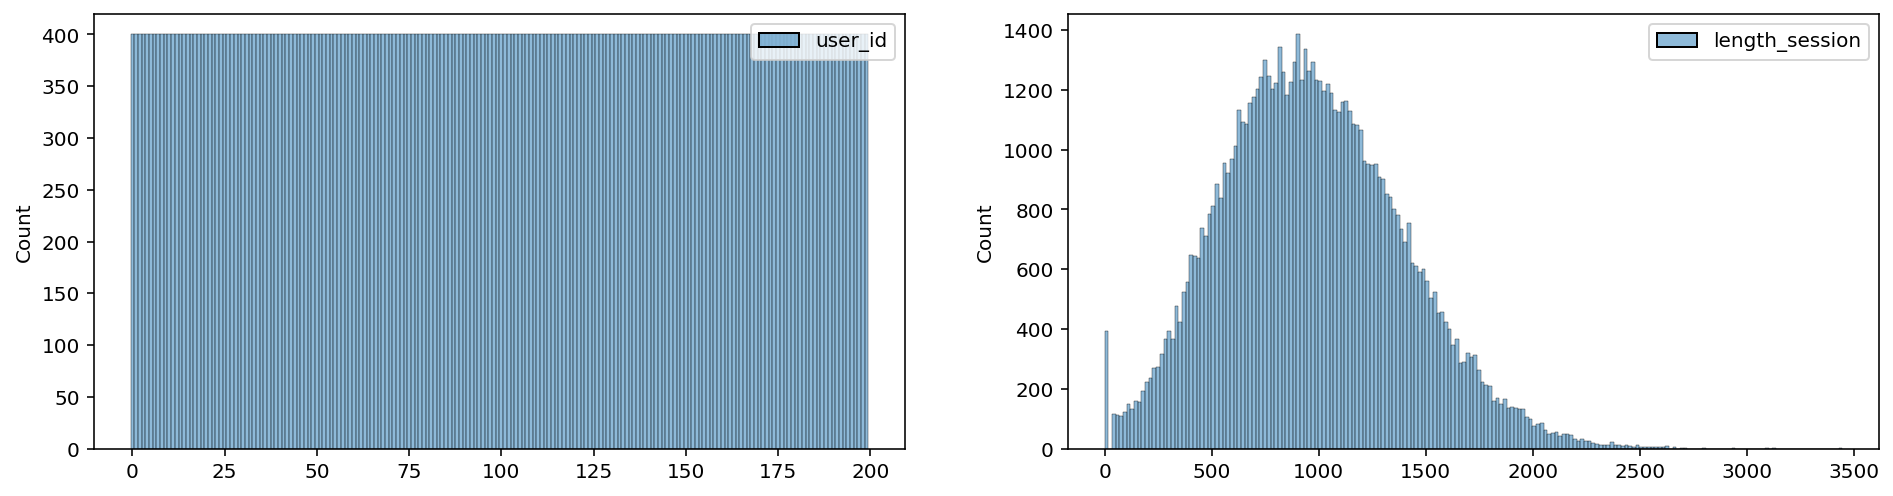

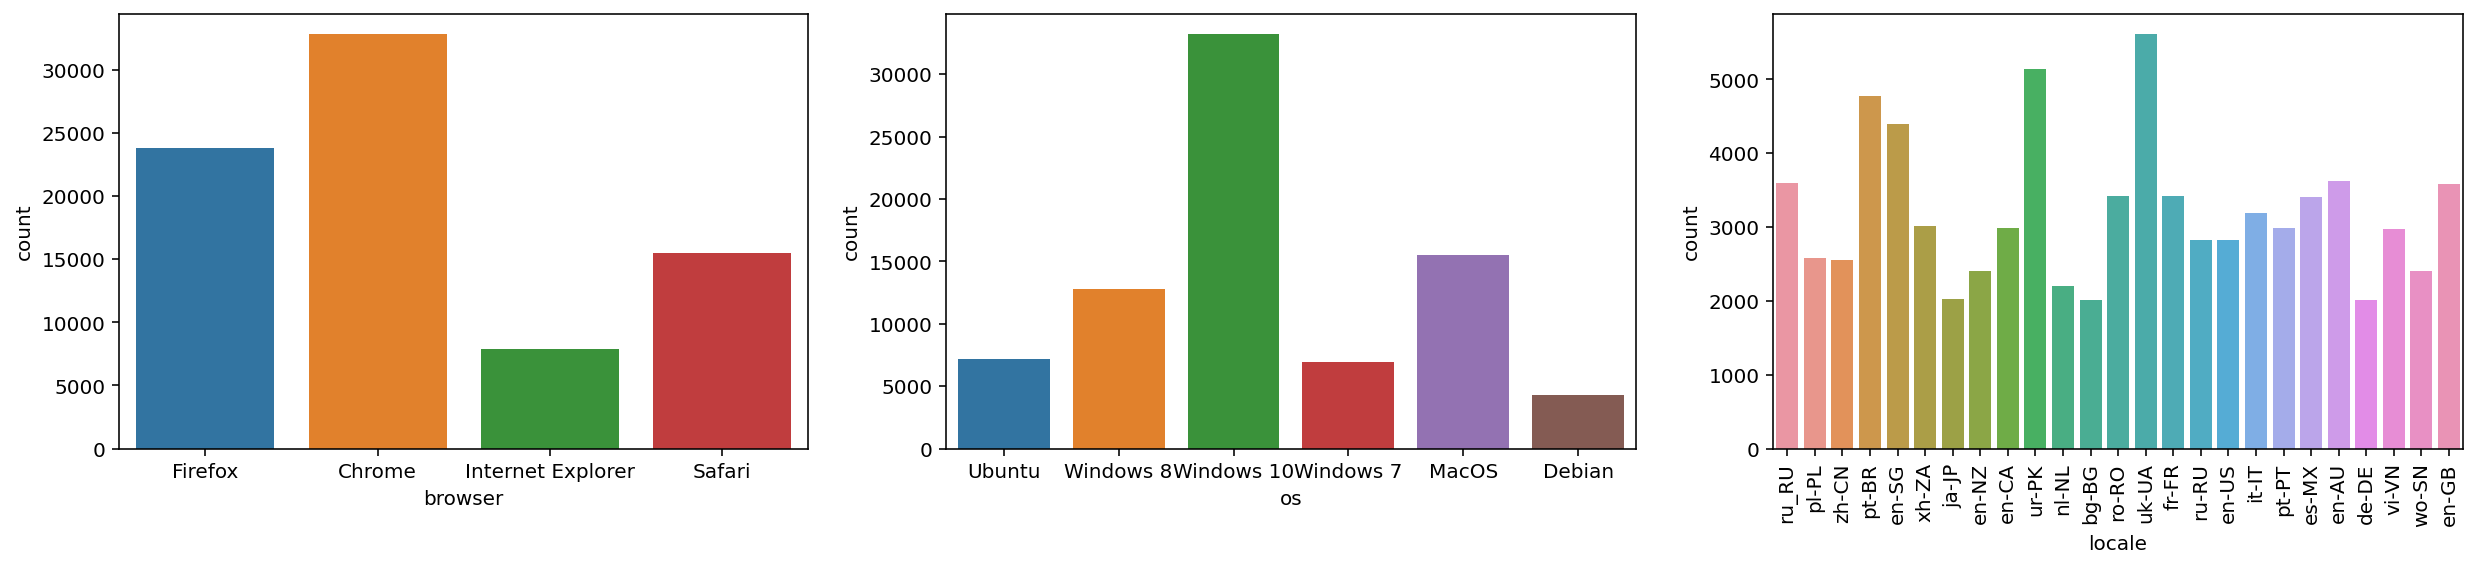

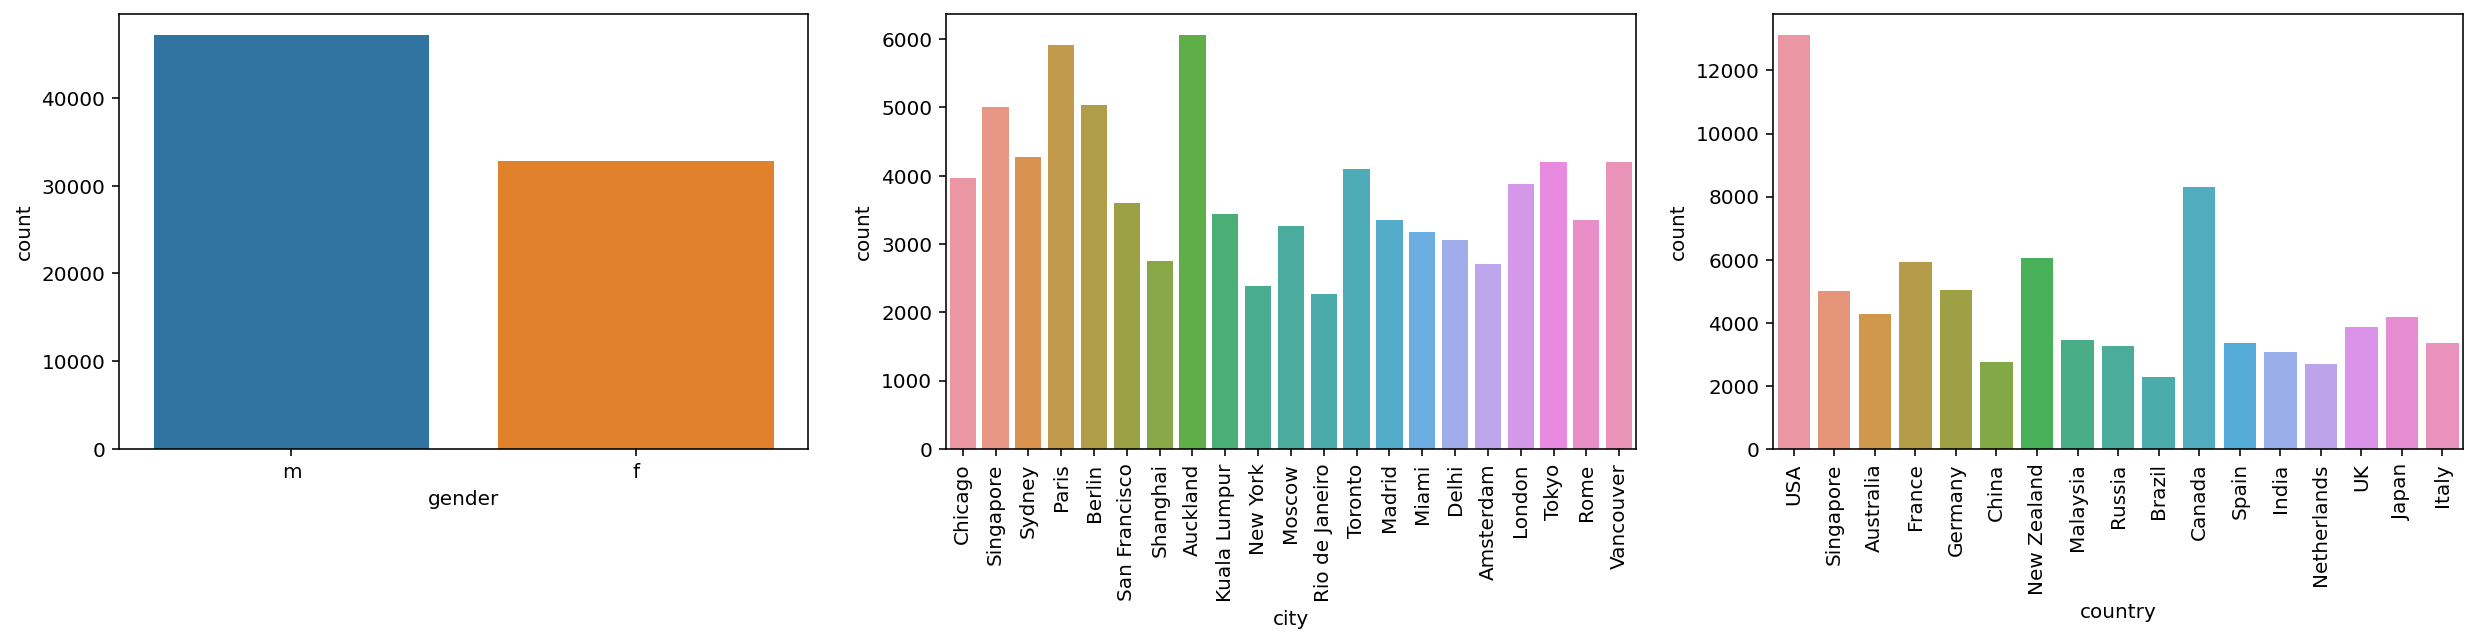

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4));
p = sns.histplot(user_sessions[['user_id']], ax=ax.flatten()[0], discrete=True);
p = sns.histplot(user_sessions[['length_session']], ax=ax.flatten()[1], bins=200);

fig, ax = plt.subplots(1, 3, figsize=(21, 4));
p = sns.countplot(data=user_sessions, x='browser', ax=ax.flatten()[0])
p = sns.countplot(data=user_sessions, x='os', ax=ax.flatten()[1])
p = sns.countplot(data=user_sessions, x='locale', ax=ax.flatten()[2])
for label in ax.flatten()[2].get_xticklabels():
    label.set_rotation(90);

fig, ax = plt.subplots(1, 3, figsize=(21, 4));
p = sns.countplot(data=user_sessions, x='gender', ax=ax.flatten()[0])
p = sns.countplot(data=user_sessions, x='city', ax=ax.flatten()[1])
for label in ax.flatten()[1].get_xticklabels():
    label.set_rotation(90);
p = sns.countplot(data=user_sessions, x='country', ax=ax.flatten()[2])
for label in ax.flatten()[2].get_xticklabels():
    label.set_rotation(90);

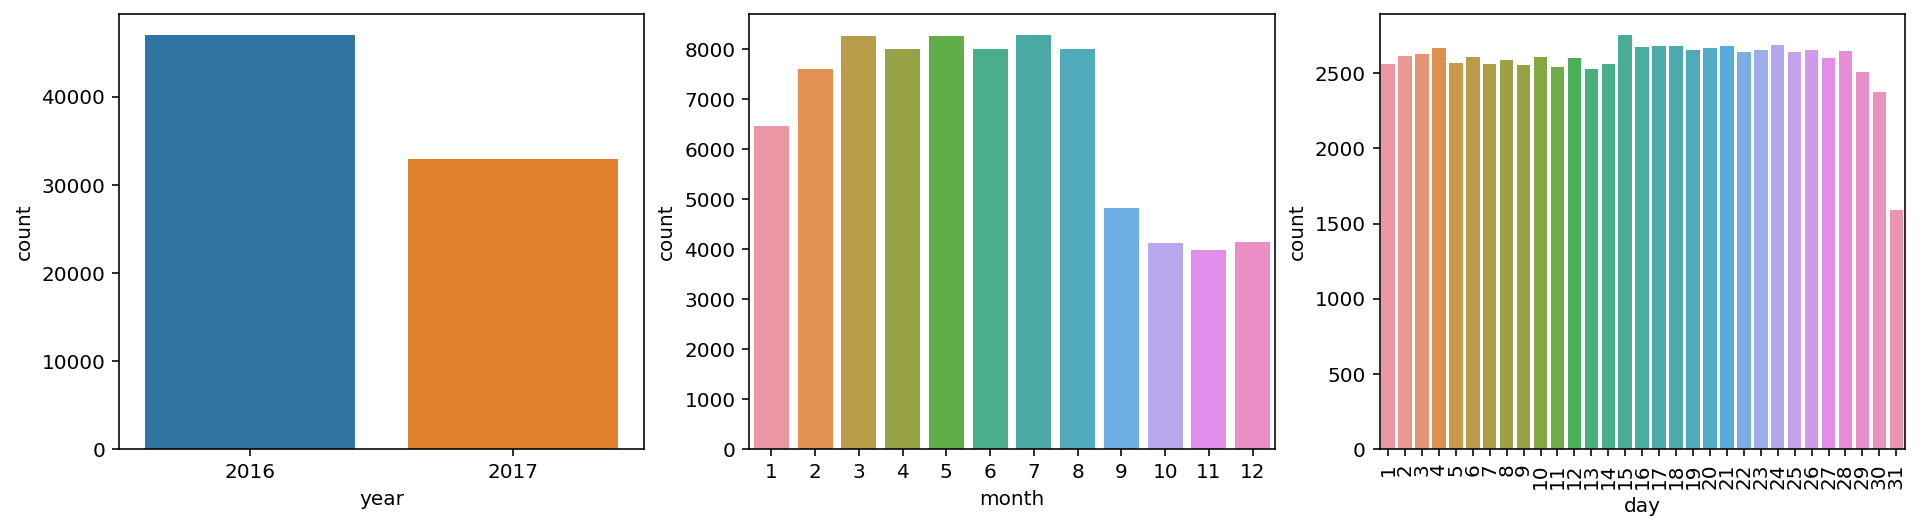

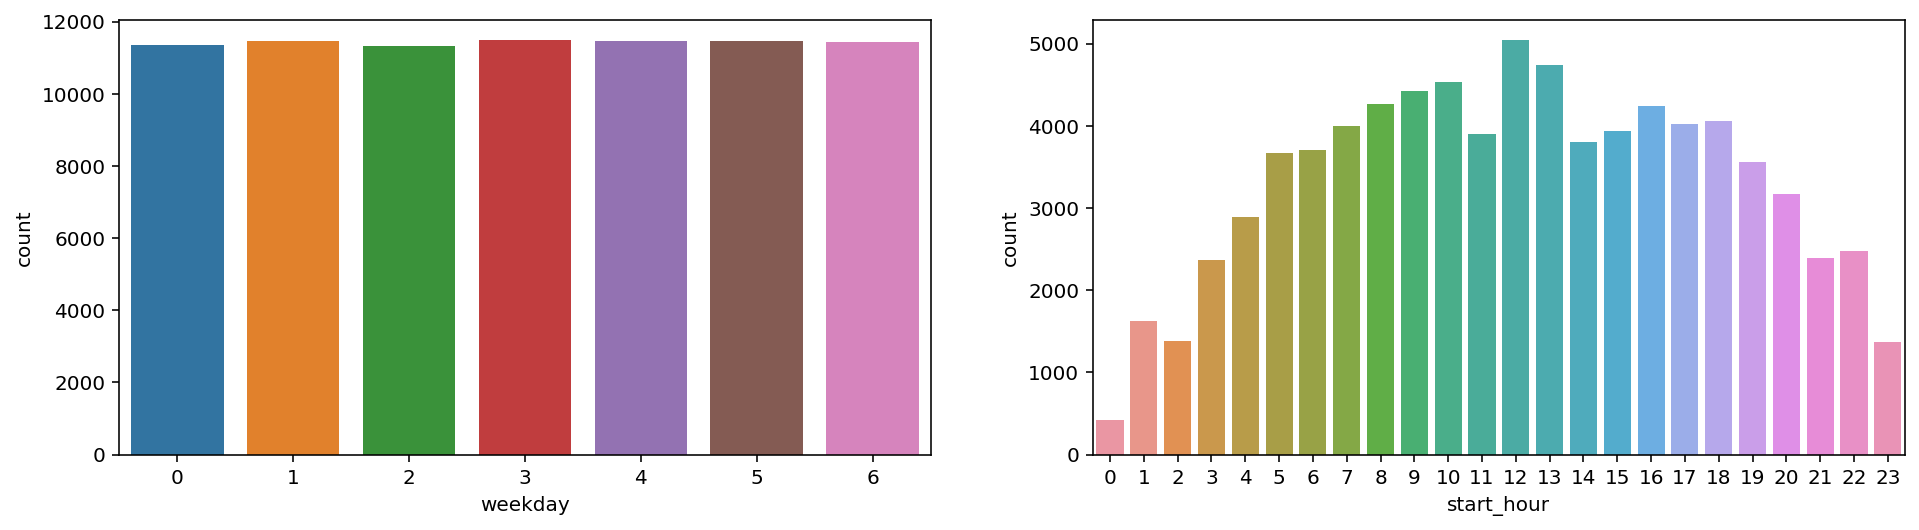

In [1]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4));
p = sns.countplot(data=user_sessions, x='year', ax=ax.flatten()[0])
p = sns.countplot(data=user_sessions, x='month', ax=ax.flatten()[1])
p = sns.countplot(data=user_sessions, x='day', ax=ax.flatten()[2])
for label in ax.flatten()[2].get_xticklabels():
    label.set_rotation(90);
fig, ax = plt.subplots(1, 2, figsize=(16, 4));
p = sns.countplot(data=user_sessions, x='weekday', ax=ax.flatten()[0])
p = sns.countplot(data=user_sessions, x='start_hour', ax=ax.flatten()[1])

### Joe&rsquo;s Characteristics



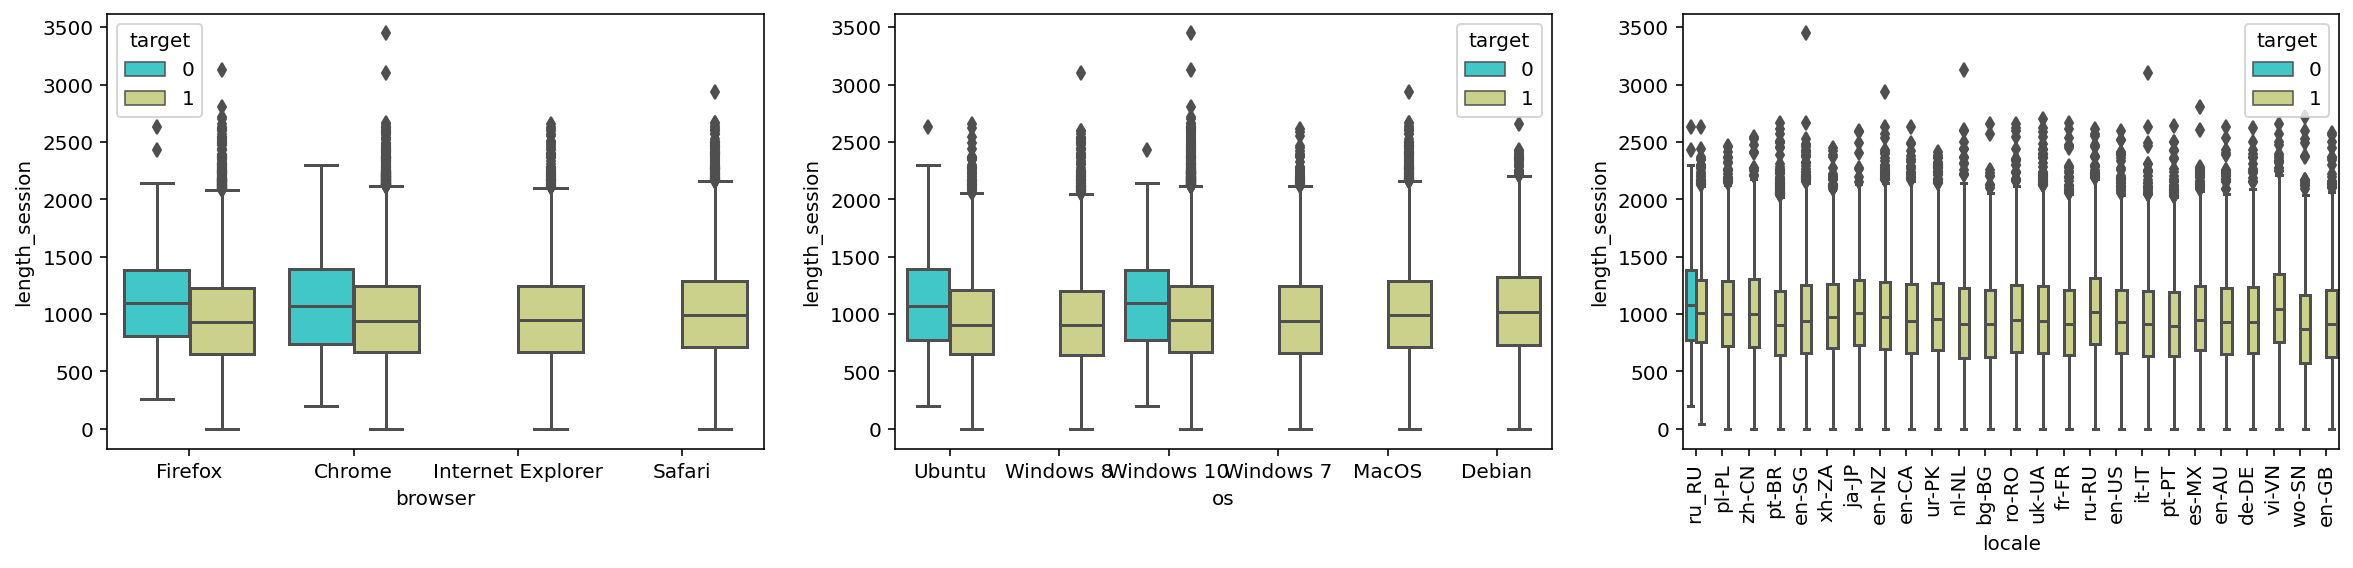

In [1]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
for i, feat in enumerate(['browser', 'os', 'locale']):
    sub_ax = ax.flatten()[i]
    p = sns.boxplot(x=feat, y='length_session', hue='target', data=user_sessions, palette='rainbow', ax=sub_ax)
set_xlabel_rotation(ax.flatten()[2], 90)

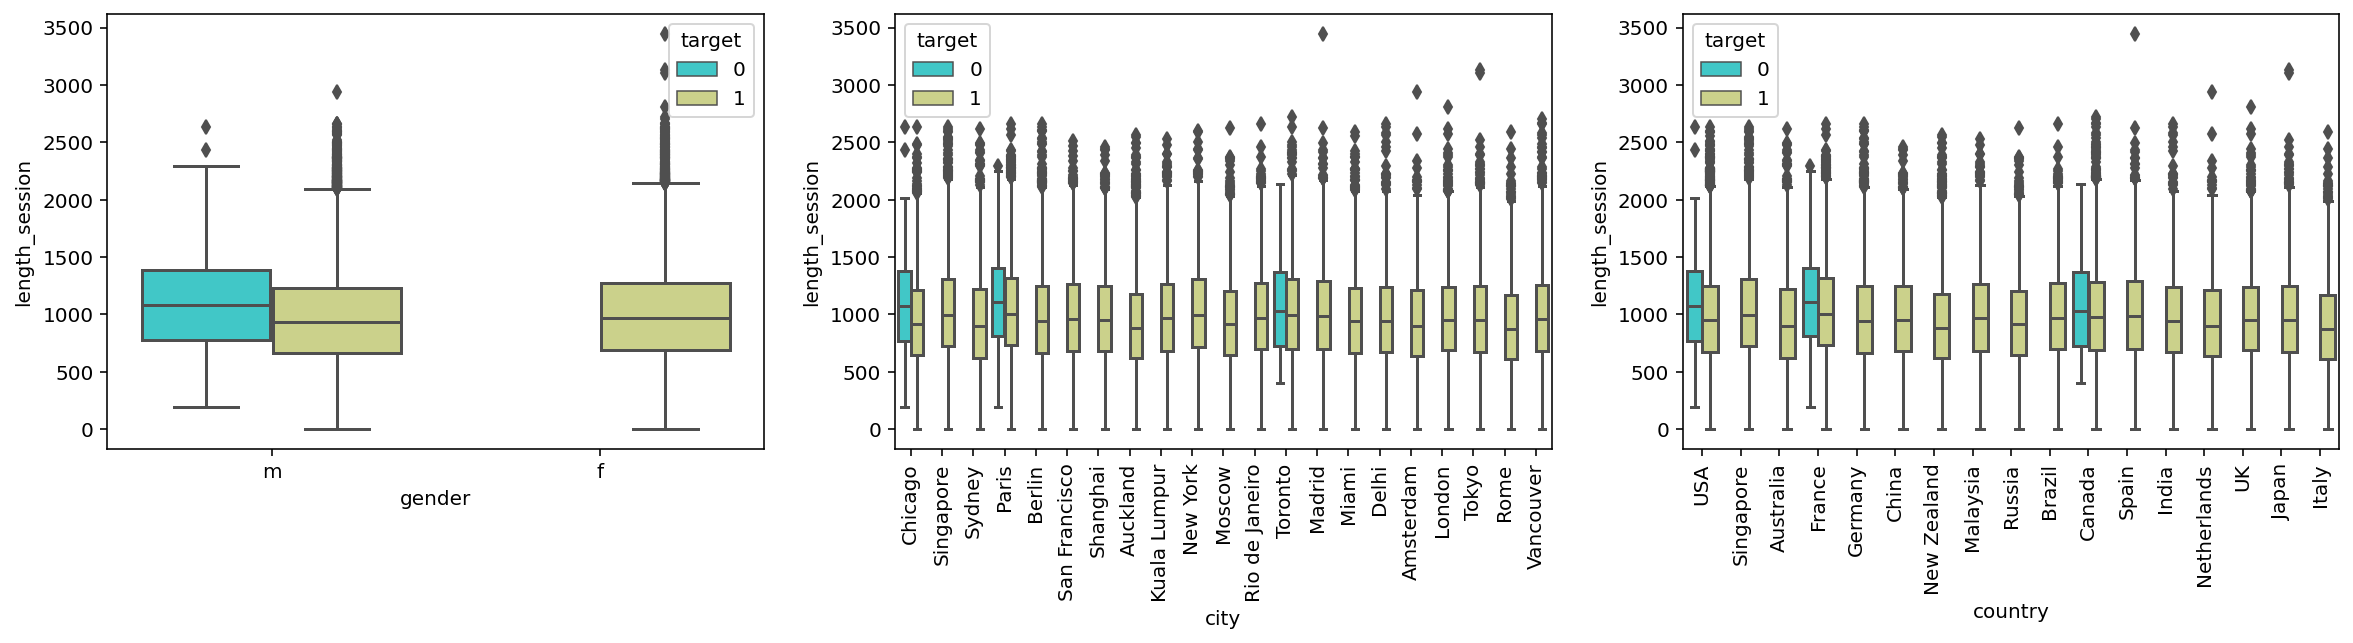

In [1]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
for i, feat in enumerate(['gender', 'city', 'country']):
    sub_ax = ax.flatten()[i]
    p = sns.boxplot(x=feat, y='length_session', hue='target', data=user_sessions, palette='rainbow', ax=sub_ax)
    if feat != 'gender':
        set_xlabel_rotation(sub_ax, 90)

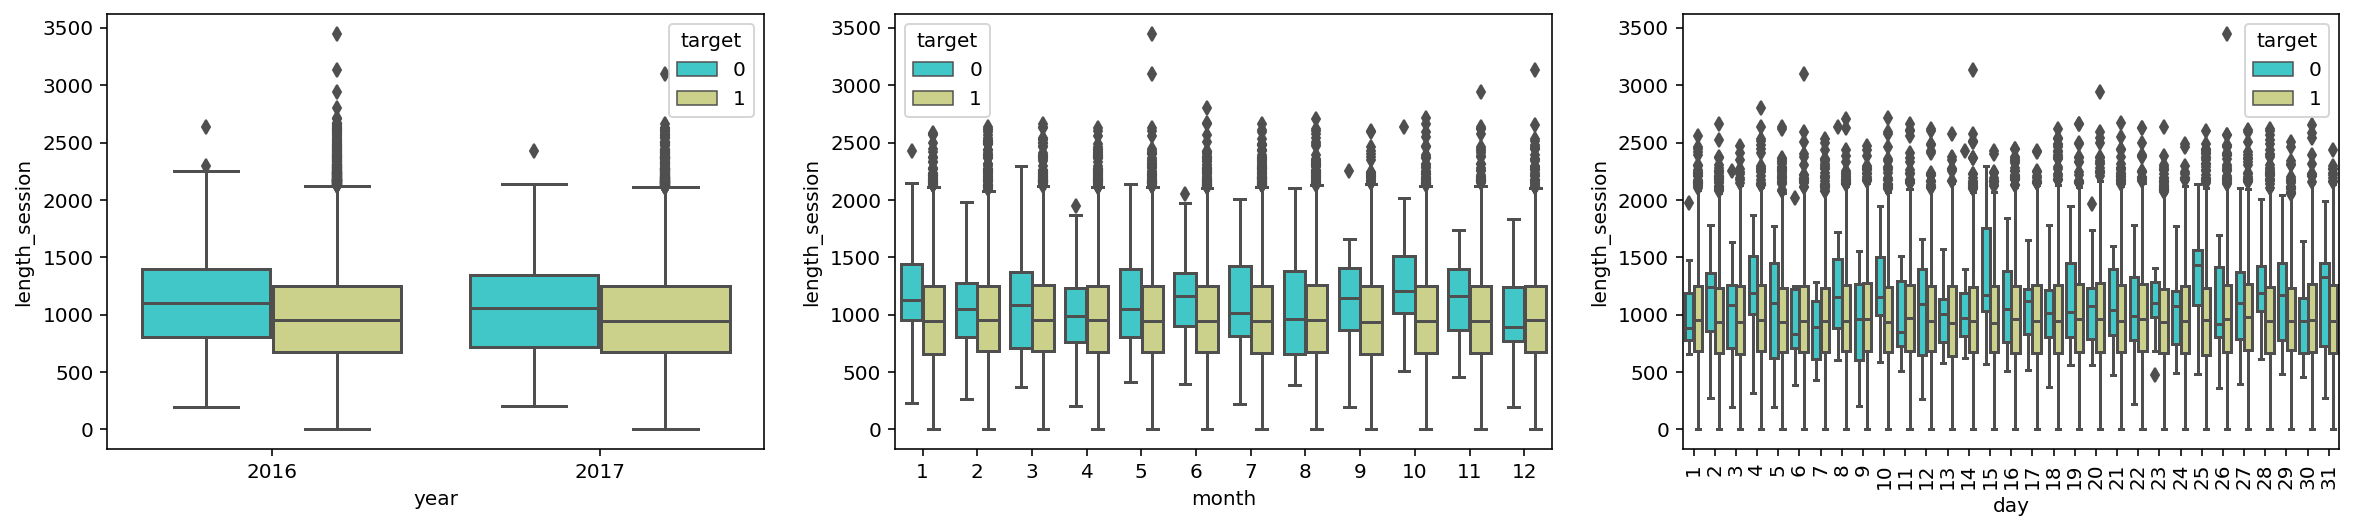

In [1]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
for i, feat in enumerate(['year', 'month', 'day']):
    sub_ax = ax.flatten()[i]
    p = sns.boxplot(x=feat, y='length_session', hue='target', data=user_sessions, palette='rainbow', ax=sub_ax)
    if feat == 'day':
        set_xlabel_rotation(sub_ax, 90)

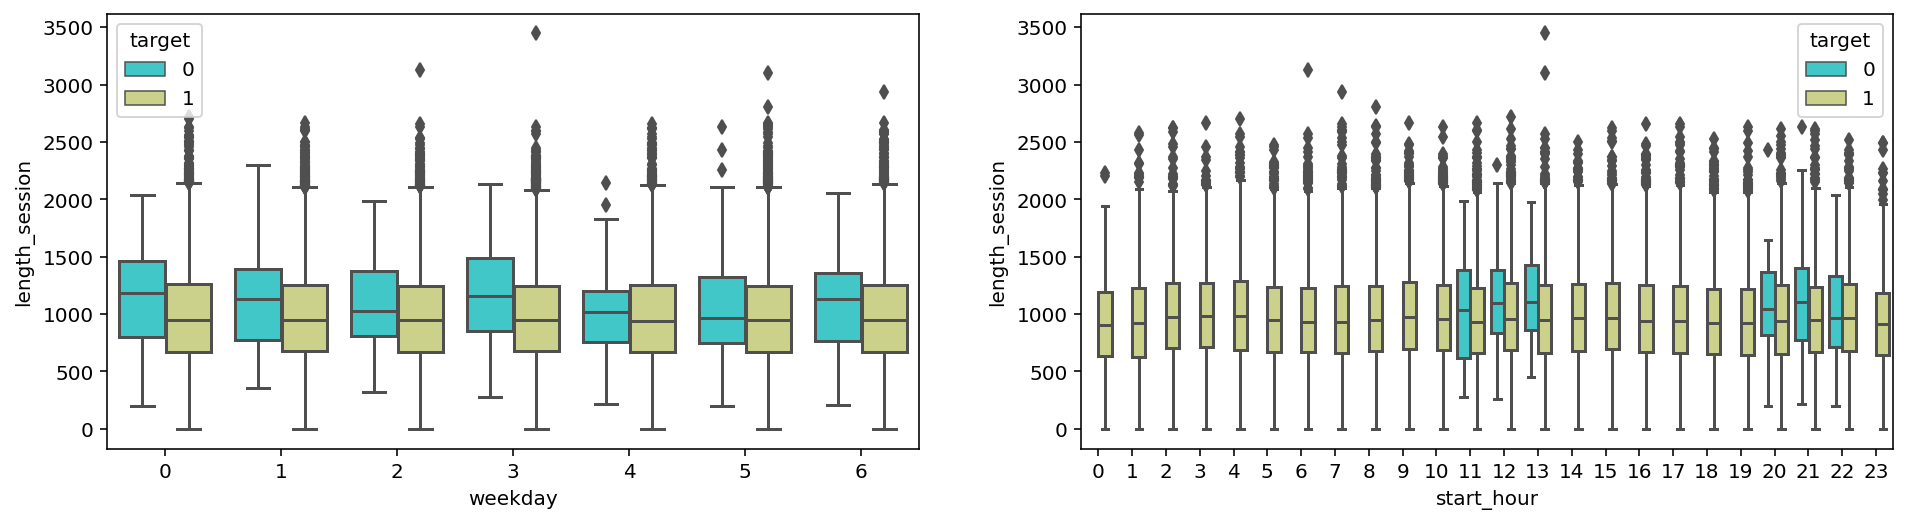

In [1]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
for i, feat in enumerate(['weekday', 'start_hour']):
    sub_ax = ax.flatten()[i]
    p = sns.boxplot(x=feat, y='length_session', hue='target', data=user_sessions, palette='rainbow', ax=sub_ax)

# Features / target correlation

### Category features vs. target correlation with contingency analysis / Cramer&rsquo;s V



#### Cramer&rsquo;s V



In [24]:
cat_cols = ['browser', 'os', 'locale', 'gender', 'country', 'city', 'year', 'month', 'day', 'weekday', 'start_hour']
cat_feat_target_crv = pd.Series([cramers_v(user_sessions[cat_feat], user_sessions['user_id']) for cat_feat in cat_cols], index = cat_cols, name='CramersV').sort_values(ascending=False)
cat_feat_target_crv

gender        0.998762
browser       0.876672
locale        0.867128
os            0.854367
country       0.780666
city          0.777243
start_hour    0.423355
year          0.000000
month         0.000000
day           0.000000
weekday       0.000000
Name: CramersV, dtype: float64

#### Theil&rsquo;s U



In [25]:
cat_cols = ['browser', 'os', 'locale', 'gender', 'country', 'city', 'year', 'month', 'day', 'weekday', 'start_hour']
cat_feat_target_thu = pd.Series([theils_u(user_sessions[feat], user_sessions['user_id']) for feat in cat_cols], index = cat_cols, name='TheilsU').sort_values(ascending=False)
cat_feat_target_thu

gender        1.000000
locale        0.900952
os            0.827354
city          0.813216
country       0.800623
browser       0.799798
start_hour    0.377777
day           0.003827
weekday       0.001455
month         0.001136
year          0.000548
Name: TheilsU, dtype: float64

#### Plot



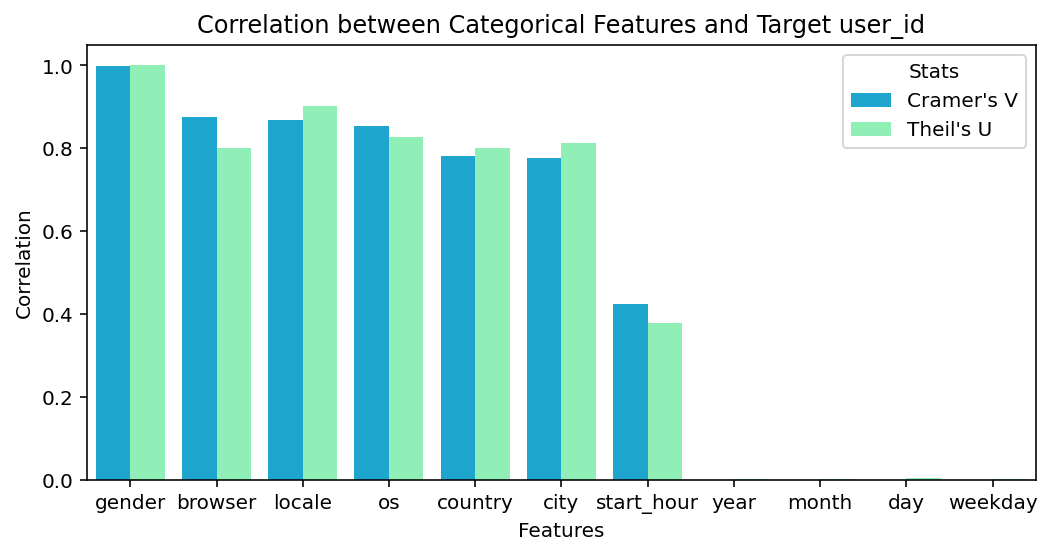

In [1]:
cat_target_corr = pd.DataFrame({'Correlation':cat_feat_target_crv})
cat_target_corr['Stats'] = "Cramer's V"
df = pd.DataFrame({'Correlation': cat_feat_target_thu})
df['Stats'] = "Theil's U"
cat_target_corr = cat_target_corr.append(df).reset_index().rename(columns={'index': 'Features'})
fig, ax = plt.subplots(1, 1, figsize=(8.5, 4));
p = sns.barplot(data=cat_target_corr, x='Features', y='Correlation', hue='Stats', palette=sns.color_palette('rainbow', 3))
plt.title('Correlation between Categorical Features and Target user_id');

### Numerical features vs. target correlation with correlation ratio ( &eta; )



In [26]:
num_cols = ['length_session', 'start_sin', 'start_cos']
num_target_corr = pd.Series([correlation_ratio(user_sessions['user_id'], user_sessions[feat]) for feat in num_cols], index = num_cols, name='CorrRatio').sort_values(ascending=False)
num_target_corr

start_sin         0.813011
start_cos         0.728270
length_session    0.353507
Name: CorrRatio, dtype: float64

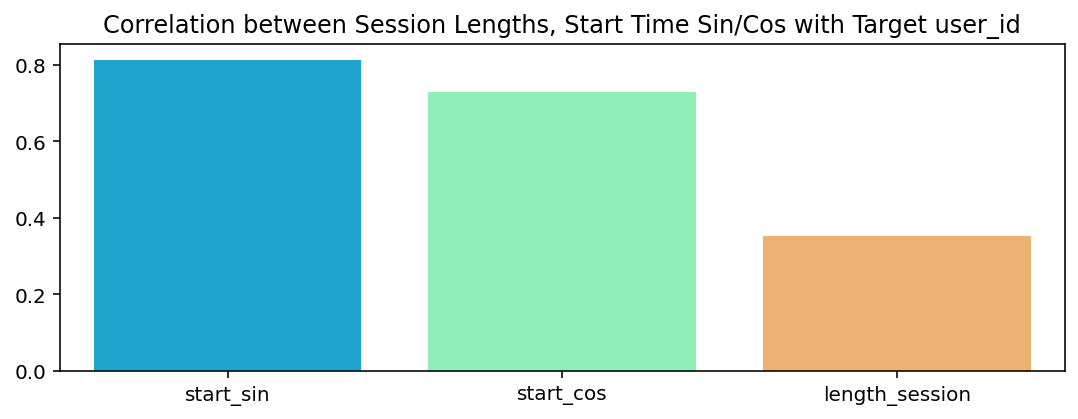

In [1]:
fig, ax = plt.subplots(1, 1, figsize=(9, 3));
p = sns.barplot(x=num_target_corr.index, y=num_target_corr.values, palette=sns.color_palette('rainbow', 3))
plt.title('Correlation between Session Lengths, Start Time Sin/Cos with Target user_id');

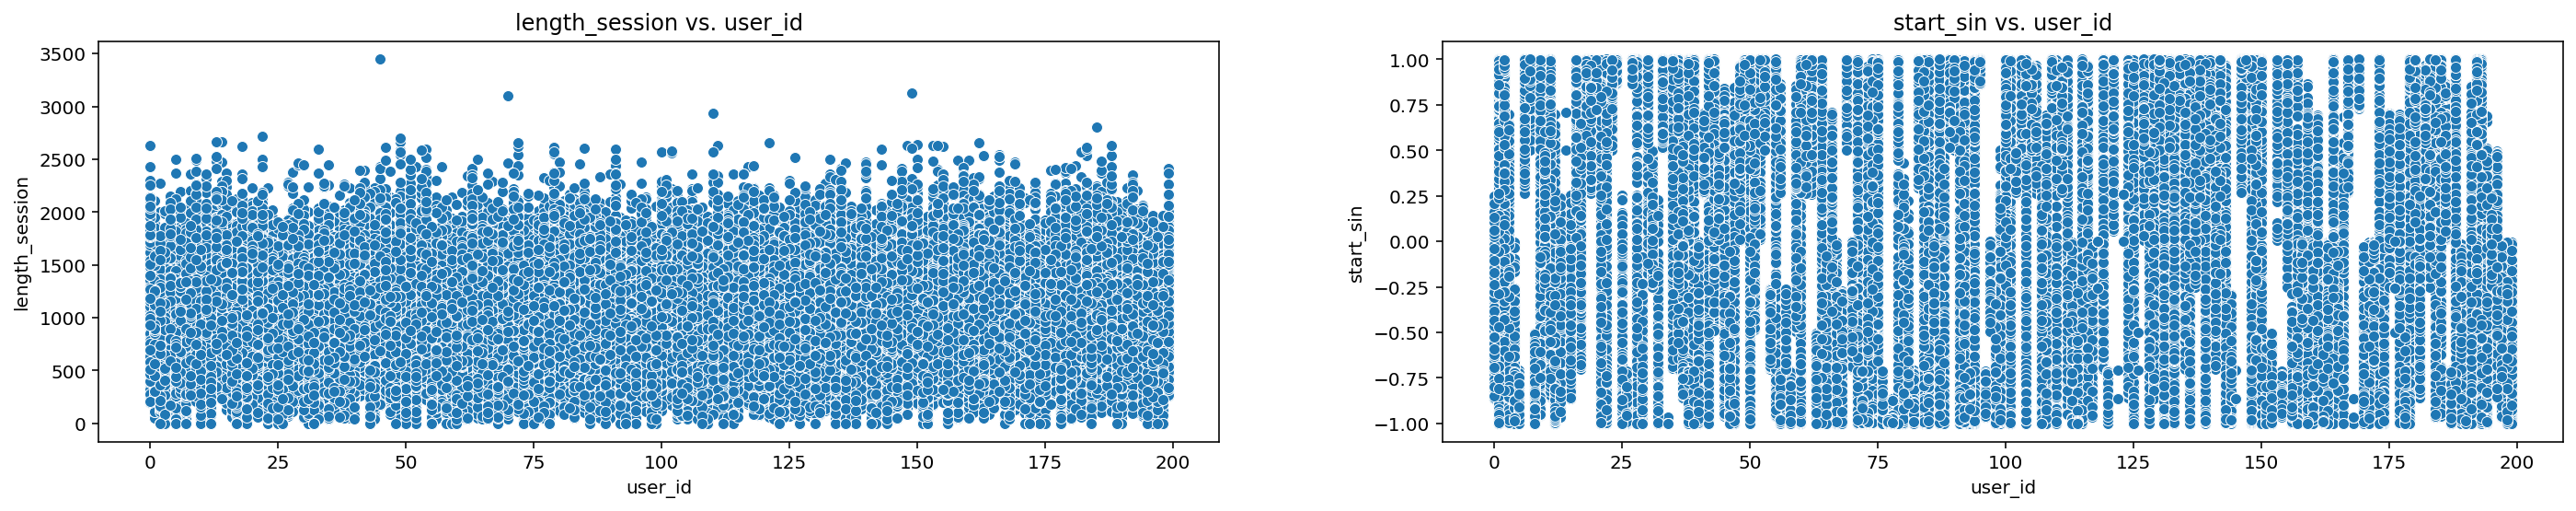

In [1]:
fig, ax = plt.subplots(1, 2, figsize=(24,4))
for i, col in enumerate(['length_session', 'start_sin']):
    sub_ax = ax.flatten()[i]
    p = sns.scatterplot(data=user_sessions, x='user_id', y=col, ax=sub_ax)#, label=col)
    #sub_ax.legend(loc='upper right');
    t = sub_ax.set_title(f'{col} vs. user_id')

# Data pipeline for modeling

### Definitions summarized from exploratory analysis above



In [27]:
def load_data(data_file_path: Path) -> pd.DataFrame:
    """Load data from json file."""
    with open(data_file_path, "r") as f:
        data_json_struct = json.loads(f.read())
    user_sessions = pd.DataFrame(data_json_struct)
    return user_sessions


class TimezoneByCity:
    def __init__(self):
        self.geolocator = Nominatim(user_agent="geoapiExercises")
        self.tzfinder = TimezoneFinder()

    def tz_name(self, city: str):
        loc = self.geolocator.geocode(city)
        tz_name = self.tzfinder.timezone_at(lng=loc.longitude, lat=loc.latitude)
        return tz_name

    def tz(self, city: str):
        tz_name = self.tz_name(city)
        return pytz.timezone(tz_name)


def prepare_data(user_sessions: pd.DataFrame, has_labels=False) -> pd.DataFrame:
    # impute empty sites
    empty_sites_index = user_sessions.query("sites.str.len() == 0").index
    user_sessions.loc[empty_sites_index, "sites"] = user_sessions.loc[
        empty_sites_index
    ]["sites"].apply(lambda sites: sites + [{"site": "NONE.NONE", "length": 0}])

    # Combine date/time columns and convert from string to datetime type
    user_sessions["start_dt"] = pd.to_datetime(
        user_sessions["date"] + " " + user_sessions["time"], utc=True
    )

    # Convert to local date time
    tz_by_city = TimezoneByCity()
    timezone_tbl = {
        loc: tz_by_city.tz_name(loc.split("/")[1])
        for loc in user_sessions.location.unique()
    }
    user_sessions["local_time"] = user_sessions.apply(
        lambda row: row["start_dt"]
        .tz_convert(timezone_tbl[row["location"]])
        .tz_localize(None),
        axis=1,
    )

    # Split start date/time to year / month / day / weekday and start_hour
    user_sessions["year"] = user_sessions.local_time.dt.year
    user_sessions["month"] = user_sessions.local_time.dt.month
    user_sessions["day"] = user_sessions.local_time.dt.day
    user_sessions["weekday"] = user_sessions.local_time.dt.weekday
    user_sessions["start_hour"] = user_sessions.local_time.dt.hour

    # Sine/Cosine transform of local start time
    start_dt_normalized = (
        (user_sessions["local_time"] - user_sessions["local_time"].dt.normalize())
        / pd.Timedelta("1 second")
        / 86400
    )
    user_sessions["start_sin"] = np.sin(2 * np.pi * (start_dt_normalized))
    user_sessions["start_cos"] = np.cos(2 * np.pi * (start_dt_normalized))

    # Split location to country and city
    user_sessions[["country", "city"]] = user_sessions["location"].str.split(
        "/", expand=True
    )

    # Get total length of each user session
    user_sessions["length_session"] = user_sessions["sites"].apply(
        lambda session_sites: sum(site_entry["length"] for site_entry in session_sites)
    )

    #
    user_sessions['sites_corpus'] = user_sessions['sites'].apply(
        lambda session_sites: ' '.join(site_entry['site'] for site_entry in session_sites))

    # Drop off original date/time columns
    user_sessions.drop(
        ["time", "date", "start_dt", "local_time", "location"], axis=1, inplace=True
    )

    return user_sessions


class SiteLengthTfIdfTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_top=100, top_sites=None):
        self.n_top = n_top
        self.top_sites = top_sites
        self.top_sites_ = []
        self.tfidf = TfidfTransformer()

    def _get_topsites(self, sites):
        cnt = Counter()
        for session_sites in sites:
            for site_entry in session_sites:
                cnt.update({site_entry['site']: site_entry['length']})
        top_sites, _ = zip(*cnt.most_common(self.n_top))
        return top_sites

    def _vectorize_topsites_by_length(self, session_sites):
        topsites_len_dict = dict.fromkeys(self.top_sites_, 0)
        for site_entry in session_sites:
            site = site_entry['site']
            if site in topsites_len_dict:
                topsites_len_dict[site] += site_entry['length']
        return list(topsites_len_dict.values())

    def fit(self, X, y=None):
        if self.top_sites:
            self.top_sites_ = self.top_sites
        else:
            self.top_sites_ = self._get_topsites(X)
        topsites_length = [self._vectorize_topsites_by_length(session_sites) for session_sites in X]
        self.tfidf = self.tfidf.fit(topsites_length)
        return self

    def transform(self, X, y=None):
        topsites_length = [self._vectorize_topsites_by_length(session_sites) for session_sites in X]
        return self.tfidf.transform(topsites_length)

class SiteLengthTfIdfNGramTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_top=100, top_sites=None, ngram_min=1, ngram_max=1):
        self.n_top = n_top
        self.top_sites = top_sites
        self.ngram_min, self.ngram_max = ngram_min, ngram_max
        self.top_sites_ = []
        self.tfidf = TfidfTransformer()

    def _get_topsites(self, sites):
        cnt = Counter()
        for session_sites in sites:
            n_sites = len(session_sites)
            for n_gram in range(self.ngram_min, self.ngram_max+1):
                for i in range(0, n_sites - n_gram + 1):
                    token = ' '.join(entry['site'] for entry in session_sites[i:i+n_gram])
                    token_len = sum(entry['length'] for entry in session_sites[i:i+n_gram])
                    cnt.update({token: token_len})
        top_sites, _ = zip(*cnt.most_common(self.n_top))
        return top_sites

    def _vectorize_topsites_by_length(self, session_sites):
        topsites_len_dict = dict.fromkeys(self.top_sites_, 0)
        n_sites = len(session_sites)
        for n_gram in range(self.ngram_min, self.ngram_max+1):
            for i in range(0, n_sites - n_gram + 1):
                token = ' '.join(entry['site'] for entry in session_sites[i:i+n_gram])
                token_len = sum(entry['length'] for entry in session_sites[i:i+n_gram])
                if token in topsites_len_dict:
                    topsites_len_dict[token] += token_len
        return list(topsites_len_dict.values())

    def fit(self, X, y=None):
        if self.top_sites:
            self.top_sites_ = self.top_sites
        else:
            self.top_sites_ = self._get_topsites(X)
        topsites_length = [self._vectorize_topsites_by_length(session_sites) for session_sites in X]
        self.tfidf = self.tfidf.fit(topsites_length)
        return self

    def transform(self, X, y=None):
        topsites_length = [self._vectorize_topsites_by_length(session_sites) for session_sites in X]
        return self.tfidf.transform(topsites_length)

### Load data



In [28]:
user_sessions = load_data('dataset.json')

### Stratified Train / Test Split



In [29]:
ss_spliter = StratifiedShuffleSplit(n_splits=1, train_size=0.9, random_state=42)
train_idx, test_idx = next(ss_spliter.split(user_sessions, (user_sessions['user_id'] != 0).astype(int)))
user_sessions_train, user_sessions_test = user_sessions.loc[train_idx], user_sessions.loc[test_idx]

### Prepare data



In [30]:
def get_topsites(sites, ngram_min=1, ngram_max=1):
    cnt = Counter()
    for session_sites in sites:
        n_sites = len(session_sites)
        for n_gram in range(ngram_min, ngram_max):
            for i in range(0, n_sites - n_gram + 1):
                token = ' '.join(entry['site'] for entry in session_sites[i:i+n_gram])
                token_len = sum(entry['length'] for entry in session_sites[i:i+n_gram])
                cnt.update({token: token_len})
    top_sites, _ = zip(*cnt.most_common())
    return top_sites

joe_top_sites = get_topsites(user_sessions_train.query('user_id == 0')['sites'], ngram_min=1, ngram_max=5)
print(joe_top_sites[:10])

('mail.google.com vk.com toptal.com lenta.ru', 'mail.google.com vk.com toptal.com', 'vk.com toptal.com lenta.ru', 'mail.google.com vk.com', 'toptal.com lenta.ru', 'vk.com toptal.com', 'lenta.ru', 'slack.com', 'mail.google.com', 'toptal.com')


In [31]:
user_sessions_train = prepare_data(user_sessions_train, has_labels=True)
user_sessions_test = prepare_data(user_sessions_test, has_labels=True)
user_sessions_train.head()

,browser,os,locale,user_id,gender,sites,year,month,day,weekday,start_hour,start_sin,start_cos,country,city,length_session,sites_corpus
78644,Safari,MacOS,pt-BR,137,f,"[{'site': 'verisign.com', 'length': 104}, {'si...",2017,3,15,2,11,0.212178,-0.977231,New Zealand,Auckland,776,verisign.com booking.com ggpht.com wikimedia.o...
4059,Chrome,Windows 8,en-AU,37,m,"[{'site': 'twitter.com', 'length': 64}, {'site...",2017,3,13,0,10,0.390731,-0.920505,UK,London,1246,twitter.com openclassrooms.com wikimedia.org y...
70523,Chrome,Ubuntu,zh-CN,38,m,"[{'site': 'toptal.com', 'length': 99}, {'site'...",2016,7,27,2,21,-0.587785,0.809017,Germany,Berlin,577,toptal.com lenta.ru mail.google.com toptal.com...
42989,Firefox,Windows 8,en-GB,167,f,"[{'site': 'toptal.com', 'length': 50}, {'site'...",2016,11,2,2,6,0.999990,-0.004363,Netherlands,Amsterdam,1122,toptal.com slack.com toptal.com slack.com vdi3...
71408,Firefox,Windows 10,en-AU,117,f,"[{'site': 'instagram.com', 'length': 133}, {'s...",2017,5,26,4,22,-0.442289,0.896873,Canada,Toronto,960,instagram.com mangafox.me googlevideo.com face...


# Modeling Experiments

In [32]:
def test_rf_model(X_train, y_train, X_test, y_test, param_distribs=None, n_iter=20):
    if param_distribs is None:
        param_distribs = {
                'n_estimators': randint(low=1, high=200),
                'max_features': randint(low=1, high=X_train.shape[1]),
        }

    rf_clf = RandomForestClassifier(random_state=42)
    rnd_search = RandomizedSearchCV(rf_clf, param_distributions=param_distribs, n_iter=n_iter, scoring='f1', n_jobs=-1, refit=True, cv=5, random_state=42)
    rnd_search = rnd_search.fit(X_train, y_train)

    train_f1 = rnd_search.best_score_

    rf_clf = rnd_search.best_estimator_
    y_test_pred = rf_clf.predict(X_test)
    test_rocauc = roc_auc_score(y_test, y_test_pred, average='weighted')
    test_report = classification_report(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    return train_f1, test_f1, test_report, test_rocauc

## Baseline Performance with Random Forest Classifier

### Sites vectorized by counts and normalized with TF-IDF. All users&rsquo; sites are used.

In [33]:
cat_cols = ['browser', 'os', 'locale', 'gender', 'country', 'city', 'weekday'] # discard start_hour and uncorrelated year/month/day
num_cols = ['start_sin', 'start_cos', 'length_session']
feature_encode_pipeline = ColumnTransformer([
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num_scaler', StandardScaler(), num_cols),
    ('site_count_tfidf', TfidfVectorizer(token_pattern=r"(?u)\b[-\w@:%.\+~#=][-\w@:%.\+~#=]+\b", max_features=2000), 'sites_corpus')
])
feature_encode_pipeline = feature_encode_pipeline.fit(user_sessions_train)

X_train = feature_encode_pipeline.transform(user_sessions_train)
X_test = feature_encode_pipeline.transform(user_sessions_test)
y_train = (user_sessions_train['user_id'] == 0).astype(int).values  # set joe as positive label so we can use f1 binary metric
y_test = (user_sessions_test['user_id'] == 0).astype(int).values

train_f1, test_f1, test_report, test_rocauc = test_rf_model(X_train, y_train, X_test, y_test, n_iter=20)

print("Train F1 score: ", train_f1)
print("Test F1 score: ", test_f1)
print(test_report)
print('Test weighted ROC AUC score: ', test_rocauc)

Train F1 score:  0.5167745764274485
Test F1 score:  0.4307692307692308
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7960
           1       0.56      0.35      0.43        40

    accuracy                           1.00      8000
   macro avg       0.78      0.67      0.71      8000
weighted avg       0.99      1.00      0.99      8000

Test weighted ROC AUC score:  0.6743090452261307


### Site vectorized by &ldquo;Length&rdquo; and normalized with TF-IDF. All users&rsquo; sites are used.

In [34]:
cat_cols = ['browser', 'os', 'locale', 'gender', 'country', 'city', 'weekday'] # discard start_hour and uncorrelated year/month/day
num_cols = ['start_sin', 'start_cos', 'length_session']
feature_encode_pipeline = ColumnTransformer([
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num_scaler', StandardScaler(), num_cols),
    ('site_length_tfidf', SiteLengthTfIdfNGramTransformer(n_top=2000, ngram_min=1, ngram_max=1), 'sites'),
])
feature_encode_pipeline = feature_encode_pipeline.fit(user_sessions_train)

X_train = feature_encode_pipeline.transform(user_sessions_train)
X_test = feature_encode_pipeline.transform(user_sessions_test)
y_train = (user_sessions_train['user_id'] == 0).astype(int).values  # set joe as positive label so we can use f1 binary metric
y_test = (user_sessions_test['user_id'] == 0).astype(int).values

train_f1, test_f1, test_report, test_rocauc = test_rf_model(X_train, y_train, X_test, y_test, n_iter=20)

print("Train F1 score: ", train_f1)
print("Test F1 score: ", test_f1)
print(test_report)
print('Test weighted ROC AUC score: ', test_rocauc)

Train F1 score:  0.5115044457756323
Test F1 score:  0.5161290322580645
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7960
           1       0.73      0.40      0.52        40

    accuracy                           1.00      8000
   macro avg       0.86      0.70      0.76      8000
weighted avg       1.00      1.00      1.00      8000

Test weighted ROC AUC score:  0.6996231155778895


## Site Lengths TF-IDF - Joe&rsquo;s Visited Sites Only



- The &ldquo;sites&rdquo; entries are vectorized and encoded with TF-IDF. All sites are used.

In [35]:
cat_cols = ['browser', 'os', 'locale', 'gender', 'country', 'city', 'weekday'] # discard start_hour and uncorrelated year/month/day
num_cols = ['start_sin', 'start_cos', 'length_session']
feature_encode_pipeline = ColumnTransformer([
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num_scaler', StandardScaler(), num_cols),
    ('site_length_tfidf', SiteLengthTfIdfNGramTransformer(n_top=2000, top_sites=joe_top_sites, ngram_min=1, ngram_max=1), 'sites'),
])
feature_encode_pipeline = feature_encode_pipeline.fit(user_sessions_train)

X_train = feature_encode_pipeline.transform(user_sessions_train)
X_test = feature_encode_pipeline.transform(user_sessions_test)
y_train = (user_sessions_train['user_id'] == 0).astype(int).values  # set joe as positive label so we can use f1 binary metric
y_test = (user_sessions_test['user_id'] == 0).astype(int).values

train_f1, test_f1, test_report, test_rocauc = test_rf_model(X_train, y_train, X_test, y_test, n_iter=20)

print("Train F1 score: ", train_f1)
print("Test F1 score: ", test_f1)
print(test_report)
print('Test weighted ROC AUC score: ', test_rocauc)

Train F1 score:  0.6831920539456898
Test F1 score:  0.27450980392156865
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7960
           1       0.64      0.17      0.27        40

    accuracy                           1.00      8000
   macro avg       0.82      0.59      0.64      8000
weighted avg       0.99      1.00      0.99      8000

Test weighted ROC AUC score:  0.587248743718593


-   Overfit since only Joe&rsquo;s visited sites are selected in the training set.



## Site Lengths TF-IDF - All Users&rsquo; Sites and N-Gram = (2,3,4,5)



In [36]:
cat_cols = ['browser', 'os', 'locale', 'gender', 'country', 'city', 'weekday'] # discard start_hour and uncorrelated year/month/day
num_cols = ['start_sin', 'start_cos', 'length_session']
feature_encode_pipeline = ColumnTransformer([
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num_scaler', StandardScaler(), num_cols),
    ('site_length_tfidf', SiteLengthTfIdfNGramTransformer(n_top=2000, ngram_min=2, ngram_max=5), 'sites'),
])
feature_encode_pipeline = feature_encode_pipeline.fit(user_sessions_train)

X_train = feature_encode_pipeline.transform(user_sessions_train)
X_test = feature_encode_pipeline.transform(user_sessions_test)
y_train = (user_sessions_train['user_id'] == 0).astype(int).values  # set joe as positive label so we can use f1 binary metric
y_test = (user_sessions_test['user_id'] == 0).astype(int).values

train_f1, test_f1, test_report, test_rocauc = test_rf_model(X_train, y_train, X_test, y_test, n_iter=20)

print("Train F1 score: ", train_f1)
print("Test F1 score: ", test_f1)
print(test_report)
print('Test weighted ROC AUC score: ', test_rocauc)

Train F1 score:  0.8387930859210064
Test F1 score:  0.8918918918918919
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7960
           1       0.97      0.82      0.89        40

    accuracy                           1.00      8000
   macro avg       0.98      0.91      0.95      8000
weighted avg       1.00      1.00      1.00      8000

Test weighted ROC AUC score:  0.9124371859296482


-   Test F1 improved from 0.52 to 0.89, but there is a gap between train vs. test scores, an indicator of slight overfitting.



## Site Counts TF-IDF - All Users&rsquo; Sites and N-Gram = (2, 3, 4, 5)

In [37]:
cat_cols = ['browser', 'os', 'locale', 'gender', 'country', 'city', 'weekday'] # discard start_hour and uncorrelated year/month/day
num_cols = ['start_sin', 'start_cos', 'length_session']
feature_encode_pipeline = ColumnTransformer([
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num_scaler', StandardScaler(), num_cols),
    ('site_count_tfidf', TfidfVectorizer(token_pattern=r"(?u)\b[-\w@:%.\+~#=][-\w@:%.\+~#=]+\b", ngram_range=(2,5), max_features=2000), 'sites_corpus'),
])
feature_encode_pipeline = feature_encode_pipeline.fit(user_sessions_train)

X_train = feature_encode_pipeline.transform(user_sessions_train)
X_test = feature_encode_pipeline.transform(user_sessions_test)
y_train = (user_sessions_train['user_id'] == 0).astype(int).values  # set joe as positive label so we can use f1 binary metric
y_test = (user_sessions_test['user_id'] == 0).astype(int).values

train_f1, test_f1, test_report, test_rocauc = test_rf_model(X_train, y_train, X_test, y_test, n_iter=20)

print("Train F1 score: ", train_f1)
print("Test F1 score: ", test_f1)
print(test_report)
print('Test weighted ROC AUC score: ', test_rocauc)

Train F1 score:  0.8885421796631118
Test F1 score:  0.8918918918918919
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7960
           1       0.97      0.82      0.89        40

    accuracy                           1.00      8000
   macro avg       0.98      0.91      0.95      8000
weighted avg       1.00      1.00      1.00      8000

Test weighted ROC AUC score:  0.9124371859296482


-   Test F1 and train f1 both reach 0.89.



## N-Gram=(3,4,5,6,7)

In [38]:
cat_cols = ['browser', 'os', 'locale', 'gender', 'country', 'city', 'weekday'] # discard start_hour and uncorrelated year/month/day
num_cols = ['start_sin', 'start_cos', 'length_session']
feature_encode_pipeline = ColumnTransformer([
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num_scaler', StandardScaler(), num_cols),
    ('site_count_tfidf', TfidfVectorizer(token_pattern=r"(?u)\b[-\w@:%.\+~#=][-\w@:%.\+~#=]+\b", ngram_range=(3,7), max_features=5000), 'sites_corpus'),
])
feature_encode_pipeline = feature_encode_pipeline.fit(user_sessions_train)

X_train = feature_encode_pipeline.transform(user_sessions_train)
X_test = feature_encode_pipeline.transform(user_sessions_test)
y_train = (user_sessions_train['user_id'] == 0).astype(int).values  # set joe as positive label so we can use f1 binary metric
y_test = (user_sessions_test['user_id'] == 0).astype(int).values


param_distribs = {
    'n_estimators': randint(low=50, high=1000),
    'max_features': randint(low=50, high=X_train.shape[1]),
    'max_depth': randint(low=1, high=100),
    'min_samples_leaf': randint(low=1, high=100),
    'min_samples_split': randint(low=2, high=100),
}
train_f1, test_f1, test_report, test_rocauc = test_rf_model(X_train, y_train, X_test, y_test, param_distribs, n_iter=30)

print("Train F1 score: ", train_f1)
print("Test F1 score: ", test_f1)
print(test_report)
print('Test weighted ROC AUC score: ', test_rocauc)

Train F1 score:  0.890701613536492
Test F1 score:  0.8918918918918919
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7960
           1       0.97      0.82      0.89        40

    accuracy                           1.00      8000
   macro avg       0.98      0.91      0.95      8000
weighted avg       1.00      1.00      1.00      8000

Test weighted ROC AUC score:  0.9124371859296482


## Gradient Boosting

In [39]:
cat_cols = ['browser', 'os', 'locale', 'gender', 'country', 'city', 'weekday'] # discard start_hour and uncorrelated year/month/day
num_cols = ['start_sin', 'start_cos', 'length_session']
feature_encode_pipeline = ColumnTransformer([
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num_scaler', StandardScaler(), num_cols),
    ('site_count_tfidf', TfidfVectorizer(token_pattern=r"(?u)\b[-\w@:%.\+~#=][-\w@:%.\+~#=]+\b", ngram_range=(3,7), max_features=5000), 'sites_corpus'),
])
feature_encode_pipeline = feature_encode_pipeline.fit(user_sessions_train)

X_train = feature_encode_pipeline.transform(user_sessions_train)
X_test = feature_encode_pipeline.transform(user_sessions_test)
y_train = (user_sessions_train['user_id'] == 0).astype(int).values  # set joe as positive label so we can use f1 binary metric
y_test = (user_sessions_test['user_id'] == 0).astype(int).values


param_distribs = {
    'n_estimators': randint(low=50, high=1000),
    'max_features': randint(low=50, high=X_train.shape[1]),
    'max_depth': randint(low=1, high=100),
    'min_samples_leaf': randint(low=1, high=100),
    'min_samples_split': randint(low=2, high=100),
    'n_iter_no_change': [5],
}

gb_clf = GradientBoostingClassifier(random_state=42)
gb_rnd_search = RandomizedSearchCV(gb_clf, param_distributions=param_distribs, n_iter=30, scoring='f1', n_jobs=-1, refit=True, cv=5, random_state=42)
gb_rnd_search = gb_rnd_search.fit(X_train, y_train)

pd.DataFrame(gb_rnd_search.cv_results_)[['mean_test_score', 'params']].sort_values('mean_test_score', ascending=False)

,mean_test_score,params
3,0.891193,"{'max_depth': 53, 'max_features': 819, 'min_sa..."
1,0.882380,"{'max_depth': 21, 'max_features': 516, 'min_sa..."
21,0.875765,"{'max_depth': 9, 'max_features': 2077, 'min_sa..."
18,0.870999,"{'max_depth': 80, 'max_features': 387, 'min_sa..."
6,0.867848,"{'max_depth': 60, 'max_features': 1025, 'min_s..."
0,0.862261,"{'max_depth': 52, 'max_features': 910, 'min_sa..."
5,0.857278,"{'max_depth': 89, 'max_features': 524, 'min_sa..."
22,0.852842,"{'max_depth': 11, 'max_features': 441, 'min_sa..."
28,0.849273,"{'max_depth': 14, 'max_features': 920, 'min_sa..."
15,0.847441,"{'max_depth': 44, 'max_features': 211, 'min_sa..."


In [40]:
y_test_pred = gb_rnd_search.best_estimator_.predict(X_test)

print('balanced_accuracy:', balanced_accuracy_score(y_test, y_test_pred))
print('roc_auc:', roc_auc_score(y_test, y_test_pred, average='weighted'))
print(classification_report(y_test, y_test_pred))

balanced_accuracy: 0.937248743718593
roc_auc: 0.937248743718593
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7960
           1       0.90      0.88      0.89        40

    accuracy                           1.00      8000
   macro avg       0.95      0.94      0.94      8000
weighted avg       1.00      1.00      1.00      8000



## xgboost.XGBClassifier

In [54]:
cat_cols = ['browser', 'os', 'locale', 'gender', 'country', 'city', 'weekday'] # discard start_hour and uncorrelated year/month/day
num_cols = ['start_sin', 'start_cos', 'length_session']
feature_encode_pipeline = ColumnTransformer([
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num_scaler', StandardScaler(), num_cols),
    ('site_count_tfidf', TfidfVectorizer(token_pattern=r"(?u)\b[-\w@:%.\+~#=][-\w@:%.\+~#=]+\b", ngram_range=(3,7), max_features=5000), 'sites_corpus'),
])
feature_encode_pipeline = feature_encode_pipeline.fit(user_sessions_train)

X_train = feature_encode_pipeline.transform(user_sessions_train)
X_test = feature_encode_pipeline.transform(user_sessions_test)
y_train = (user_sessions_train['user_id'] == 0).astype(int).values  # set joe as positive label so we can use f1 binary metric
y_test = (user_sessions_test['user_id'] == 0).astype(int).values

from scipy.stats import uniform
param_distribs = {
    'n_estimators': randint(low=50, high=1000),
    'max_depth': randint(low=1, high=100),
    'reg_lambda' : uniform(0, 1),
    'min_child_weight' : randint(0, 10),
}

from xgboost import XGBClassifier
gb_clf = XGBClassifier(random_state=42, use_label_encoder=False, verbosity=0, n_iter_no_change=5)
rnd_search = RandomizedSearchCV(gb_clf, param_distributions=param_distribs, n_iter=30, scoring='f1', n_jobs=-1, refit=True, cv=5, random_state=42)
rnd_search = rnd_search.fit(X_train, y_train)

pd.DataFrame(rnd_search.cv_results_)[['mean_test_score', 'params']].sort_values('mean_test_score', ascending=False)

,mean_test_score,params
5,0.913358,"{'max_depth': 89, 'min_child_weight': 0, 'n_es..."
26,0.913192,"{'max_depth': 34, 'min_child_weight': 0, 'n_es..."
4,0.911838,"{'max_depth': 21, 'min_child_weight': 0, 'n_es..."
15,0.895591,"{'max_depth': 93, 'min_child_weight': 1, 'n_es..."
12,0.886795,"{'max_depth': 47, 'min_child_weight': 2, 'n_es..."
6,0.882590,"{'max_depth': 42, 'min_child_weight': 2, 'n_es..."
28,0.881767,"{'max_depth': 86, 'min_child_weight': 2, 'n_es..."
2,0.879623,"{'max_depth': 24, 'min_child_weight': 2, 'n_es..."
29,0.876852,"{'max_depth': 78, 'min_child_weight': 2, 'n_es..."
14,0.868178,"{'max_depth': 6, 'min_child_weight': 5, 'n_est..."


In [55]:
y_test_pred = rnd_search.best_estimator_.predict(X_test)

print('balanced_accuracy:', balanced_accuracy_score(y_test, y_test_pred))
print('roc_auc:', roc_auc_score(y_test, y_test_pred, average='weighted'))
print(classification_report(y_test, y_test_pred))

balanced_accuracy: 0.9123743718592965
roc_auc: 0.9123743718592965
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7960
           1       0.94      0.82      0.88        40

    accuracy                           1.00      8000
   macro avg       0.97      0.91      0.94      8000
weighted avg       1.00      1.00      1.00      8000



## DNN

In [56]:
cat_cols = ['browser', 'os', 'locale', 'gender', 'country', 'city', 'weekday'] # discard start_hour and uncorrelated year/month/day
num_cols = ['start_sin', 'start_cos', 'length_session']
feature_encode_pipeline = ColumnTransformer([
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num_scaler', StandardScaler(), num_cols),
    ('site_count_tfidf', TfidfVectorizer(token_pattern=r"(?u)\b[-\w@:%.\+~#=][-\w@:%.\+~#=]+\b", ngram_range=(3,7), max_features=5000), 'sites_corpus'),
])
feature_encode_pipeline = feature_encode_pipeline.fit(user_sessions_train)

X_train = feature_encode_pipeline.transform(user_sessions_train)
X_test = feature_encode_pipeline.transform(user_sessions_test)
y_train = (user_sessions_train['user_id'] == 0).astype(int).values  # set joe as positive label so we can use f1 binary metric
y_test = (user_sessions_test['user_id'] == 0).astype(int).values

In [58]:
from tensorflow import keras

dnn = keras.models.Sequential([
    keras.layers.Input(shape=(None, X_train.shape[1])),
    keras.layers.Dense(1000, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(600, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(1, activation='sigmoid'),
])
dnn.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])
history = dnn.fit(X_train, y_train, epochs=30)

Epoch 1/30


/home/ning/apps/mambaforge/envs/ml/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_1/dense_6/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_1/dense_6/embedding_lookup_sparse/Reshape:0", shape=(None, 1000), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_1/dense_6/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


2250/2250 [==============================] - 16s 7ms/step - loss: 0.0436 - acc: 0.9936
Epoch 2/30
2250/2250 [==============================] - 16s 7ms/step - loss: 0.0169 - acc: 0.9950
Epoch 3/30
2250/2250 [==============================] - 16s 7ms/step - loss: 0.0124 - acc: 0.9950
Epoch 4/30
2250/2250 [==============================] - 13s 6ms/step - loss: 0.0100 - acc: 0.9950
Epoch 5/30
2250/2250 [==============================] - 15s 7ms/step - loss: 0.0084 - acc: 0.9950
Epoch 6/30
2250/2250 [==============================] - 16s 7ms/step - loss: 0.0071 - acc: 0.9970
Epoch 7/30
2250/2250 [==============================] - 12s 5ms/step - loss: 0.0059 - acc: 0.9980
Epoch 8/30
2250/2250 [==============================] - 12s 5ms/step - loss: 0.0049 - acc: 0.9985
Epoch 9/30
2250/2250 [==============================] - 12s 5ms/step - loss: 0.0042 - acc: 0.9987
Epoch 10/30
2250/2250 [==============================] - 13s 6ms/step - loss: 0.0036 - acc: 0.9990
Epoch 11/30
2250/2250 [=======

In [59]:
y_train_pred = (dnn.predict(X_train) > 0.5).astype(int)
print(classification_report(y_train, y_train_pred))
print('roc_auc:', roc_auc_score(y_train, y_train_pred, average='macro'))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71640
           1       1.00      0.97      0.98       360

    accuracy                           1.00     72000
   macro avg       1.00      0.98      0.99     72000
weighted avg       1.00      1.00      1.00     72000

roc_auc: 0.984715242881072


In [60]:
y_test_pred = (dnn.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_test_pred))
print('roc_auc:', roc_auc_score(y_test, y_test_pred, average='macro'))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7960
           1       0.97      0.82      0.89        40

    accuracy                           1.00      8000
   macro avg       0.98      0.91      0.95      8000
weighted avg       1.00      1.00      1.00      8000

roc_auc: 0.9124371859296482


# Summary
- The dataset is small and skewed/imbalanced for binary classification
- Feature Extraction and Selection
  - Users&rsquo; visited web sites are key features in this problem.
  - Two vectorization methods are used to extract the visited websites feature:
    -  Vectorize by visiting length
    -  Vectorize by visiting counts
  - N-Gram sequences up to 7-gram are used to preserve the orders, which matter a lot for model performance.
  - TF-IDF normalization follows each vectorization method.
- Models
  - Random forest, boosting and DNN are tested without much tuning.
  - All models can reach a F1 score about 0.89-0.9 on the test dataset, indicating a performance bound with these features.